# Trabalho Prático – Análise de Desempenho  
## Ciência de Dados em Larga Escala  
## Bruno Costa e José Santos
# Grupo Z

---


**Modin** paraleliza operações do pandas usando Dask ou Ray, proporcionando uma interface semelhante à do pandas com ganhos significativos de desempenho para volumes maiores de dados. Sua principal vantagem é a facilidade de uso, pois não exige grandes mudanças no código existente, sendo popular para manipulação eficiente de dados em larga escala.

**JobLib** é uma biblioteca focada em computação paralela e cache de resultados, utilizada para acelerar tarefas pesadas em machine learning. Oferece uma forma simples de implementar paralelismo e melhora o desempenho em processos que envolvem muitos cálculos, sendo comum para paralelizar loops, armazenar resultados intermediários e otimizar pipelines.


In [1]:
import pandas as pd
import pyspark
import pyarrow
import numpy as np
import os
import requests
import time
import modin.pandas as md
from dask.distributed import Client, LocalCluster
import numpy as np
import modin.config as cfg
from joblib import parallel_backend, Parallel, delayed
import pandas as pd
import numpy as np
import time
from joblib import Parallel, delayed, dump, load

import dask.dataframe as dd
import joblib

In [2]:
cfg.Engine.put("dask")

In [3]:
client = Client()

2025-06-03 18:10:04,155 - distributed.nanny - WARNING - Restarting worker
2025-06-03 18:10:04,161 - distributed.nanny - WARNING - Restarting worker
2025-06-03 18:10:04,223 - distributed.nanny - WARNING - Restarting worker
2025-06-03 18:10:04,228 - distributed.nanny - WARNING - Restarting worker


# Dask + Modin

In [4]:
parquet_file = 'Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet'
modin_data = pd.read_parquet(parquet_file)

modin_data = modin_data.rename(columns=str.lower)

print(modin_data.columns)

Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')


# Funções benchmarks

In [5]:
def get_results(benchmarks):
    return pd.DataFrame.from_dict(benchmarks)

def read_file_parquet(df=None):
    return pd.read_parquet(parquet_file)

def count(df):
    return len(df)

def count_index_length(df):
    return len(df.index)

def mean(df):
    return df['fare_amt'].mean()

def standard_deviation(df):
    return df['fare_amt'].std()

def mean_of_sum(df):
    return (df['fare_amt'] + df['tip_amt']).mean()

def sum_columns(df):
    return (df['fare_amt'] + df['tip_amt']).sum()

def mean_of_product(df):
    return (df['fare_amt'] * df['tip_amt']).mean()

def product_columns(df):
    return (df['fare_amt'] * df['tip_amt']).sum()

def value_counts(df):
    return df['fare_amt'].value_counts()

def complicated_arithmetic_operation(df):
    theta_1 = df['start_lon']
    phi_1 = df['start_lat']
    theta_2 = df['end_lon']
    phi_2 = df['end_lat']
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180)
           * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1 - temp))
    return ret.mean()

def groupby_statistics(df):
    return df.groupby(by='passenger_count').agg({
        'fare_amt': ['mean', 'std'], 
        'tip_amt': ['mean', 'std']
    })

def join_count(df, other):
    return len(df.merge(other, left_index=True, right_index=True))

def join_data(df, other):
    return df.merge(other, left_index=True, right_index=True)

# Função Benchmark

In [6]:
def benchmark(f, df, benchmarks, name, **kwargs):
    start_time = time.time()
    ret = f(df, **kwargs)
    benchmarks['duration'].append(time.time() - start_time)
    benchmarks['task'].append(name)
    print(f"{name} took: {benchmarks['duration'][-1]} seconds")
    return benchmarks['duration'][-1]
 
def get_results(benchmarks):
    return pd.DataFrame.from_dict(benchmarks)

In [7]:
modin_benchmarks = {'duration': [], 'task': []}

In [8]:
benchmark(read_file_parquet, df=None, benchmarks=modin_benchmarks, name='read file')
benchmark(count, df=modin_data, benchmarks=modin_benchmarks, name='count')
benchmark(count_index_length, df=modin_data, benchmarks=modin_benchmarks, name='count index length')
benchmark(mean, df=modin_data, benchmarks=modin_benchmarks, name='mean')
benchmark(standard_deviation, df=modin_data, benchmarks=modin_benchmarks, name='standard deviation')
benchmark(mean_of_sum, df=modin_data, benchmarks=modin_benchmarks, name='mean of columns addition')
benchmark(sum_columns, df=modin_data, benchmarks=modin_benchmarks, name='addition of columns')
benchmark(mean_of_product, df=modin_data, benchmarks=modin_benchmarks, name='mean of columns multiplication')
benchmark(product_columns, df=modin_data, benchmarks=modin_benchmarks, name='multiplication of columns')
benchmark(value_counts, df=modin_data, benchmarks=modin_benchmarks, name='value counts')
benchmark(complicated_arithmetic_operation, df=modin_data, benchmarks=modin_benchmarks, name='complex arithmetic ops')
benchmark(groupby_statistics, df=modin_data, benchmarks=modin_benchmarks, name='groupby statistics')

read file took: 21.160189628601074 seconds
count took: 1.52587890625e-05 seconds
count index length took: 6.4373016357421875e-06 seconds
mean took: 0.08664298057556152 seconds
standard deviation took: 0.20416927337646484 seconds
mean of columns addition took: 0.0834360122680664 seconds
addition of columns took: 0.07437300682067871 seconds
mean of columns multiplication took: 0.08290219306945801 seconds
multiplication of columns took: 0.07393074035644531 seconds
value counts took: 0.30977749824523926 seconds
complex arithmetic ops took: 1.945744514465332 seconds
groupby statistics took: 0.6753318309783936 seconds


0.6753318309783936

# Guardar Resultados

In [9]:
modin_res_temp = get_results(modin_benchmarks).drop_duplicates(subset='task').set_index('task')
print(modin_res_temp)
filename = 'Resultados/modin_standard1'
modin_res_temp.to_parquet(filename)

print(f'Dados Guardados em {filename}.')

                                 duration
task                                     
read file                       21.160190
count                            0.000015
count index length               0.000006
mean                             0.086643
standard deviation               0.204169
mean of columns addition         0.083436
addition of columns              0.074373
mean of columns multiplication   0.082902
multiplication of columns        0.073931
value counts                     0.309777
complex arithmetic ops           1.945745
groupby statistics               0.675332
Dados Guardados em Resultados/modin_standard1.


### Medição com cProfile

Utilizou-se o módulo **cProfile** para medir o desempenho do código e identificar possíveis gargalos.  
Essa ferramenta permite analisar quanto tempo cada função leva a executar, ajudando a otimizar o código.

A análise foi feita sobre operações aplicadas a um DataFrame (carregado de um ficheiro Parquet), executadas num ambiente Jupyter Notebook. Os dados gerados ajudaram a compreender e melhorar a eficiência do processo.


In [10]:
import cProfile
import matplotlib.pyplot as plt
from io import StringIO
import pstats

In [11]:
def benchmark_with_cprofile(f, df, benchmarks, name, **kwargs):
    pr = cProfile.Profile()
    pr.enable()
    
    start_time = time.time()
    ret = f(df, **kwargs)
    benchmarks['duration'].append(time.time() - start_time)
    benchmarks['task'].append(name)
    print(f"{name} took: {benchmarks['duration'][-1]} seconds")
    
    pr.disable()
    pr.print_stats(sort='cumtime')  
    
    return benchmarks['duration'][-1]

# Benchmarks com CProfile

In [12]:
modin_benchmarks_cprofile = {'duration': [], 'task': []}

benchmark_with_cprofile(read_file_parquet, df=None, benchmarks=modin_benchmarks_cprofile, name='read file')
benchmark_with_cprofile(count, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='count')
benchmark_with_cprofile(count_index_length, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='count index length')
benchmark_with_cprofile(mean, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='mean')
benchmark_with_cprofile(standard_deviation, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='standard deviation')
benchmark_with_cprofile(mean_of_sum, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='mean of columns addition')
benchmark_with_cprofile(sum_columns, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='addition of columns')
benchmark_with_cprofile(mean_of_product, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='mean of columns multiplication')
benchmark_with_cprofile(product_columns, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='multiplication of columns')
benchmark_with_cprofile(value_counts, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='value counts')
benchmark_with_cprofile(complicated_arithmetic_operation, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='complex arithmetic ops')
benchmark_with_cprofile(groupby_statistics, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='groupby statistics')

read file took: 20.940146446228027 seconds
         987 function calls (982 primitive calls) in 20.940 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   20.940   20.940 631048046.py:4(read_file_parquet)
        1    0.113    0.113   20.940   20.940 parquet.py:498(read_parquet)
        1    0.000    0.000   20.827   20.827 parquet.py:239(read)
        1   11.274   11.274   11.275   11.275 pandas_compat.py:782(table_to_dataframe)
        1    0.000    0.000    9.551    9.551 core.py:1764(read_table)
        1    9.550    9.550    9.550    9.550 core.py:1410(read)
        1    0.001    0.001    0.001    0.001 core.py:1273(__init__)
        1    0.000    0.000    0.001    0.001 pandas_compat.py:941(_deserialize_column_index)
        1    0.000    0.000    0.000    0.000 parquet.py:85(_get_path_or_handle)
        1    0.000    0.000    0.000    0.000 pandas_compat.py:1118(_reconstruct_columns_from_m

0.6160988807678223

In [13]:
results_modin = pd.DataFrame.from_dict(modin_benchmarks_cprofile)

# Gráfico de Barras para cada operação

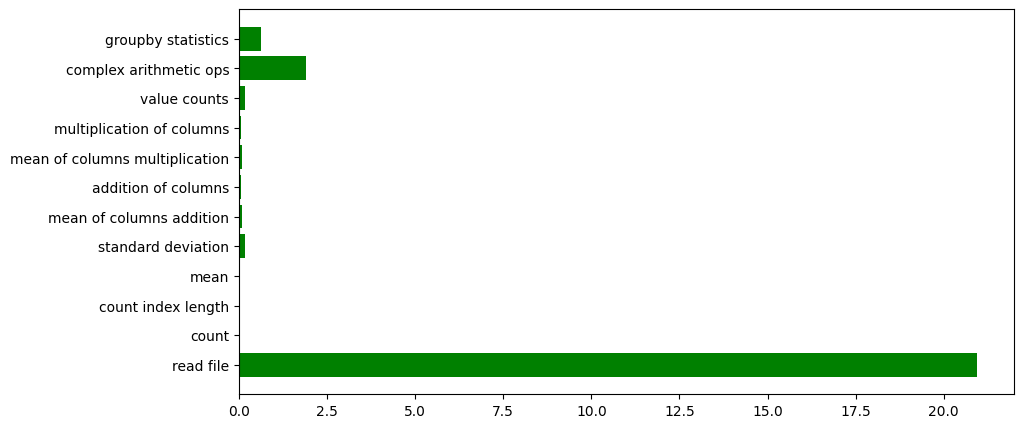

In [14]:
plt.figure(figsize=(10, 5))
plt.barh(results_modin['task'], results_modin['duration'], color='green')
plt.show()

### Análise de Desempenho

A leitura do ficheiro é a operação que mais consome tempo, destacando-se das demais.  
Operações como cálculos aritméticos complexos e estatísticas por agrupamento também têm algum peso, mas são consideravelmente mais rápidas que a leitura.  



# Gráfico de Pizza para tempo gasto em cada operação

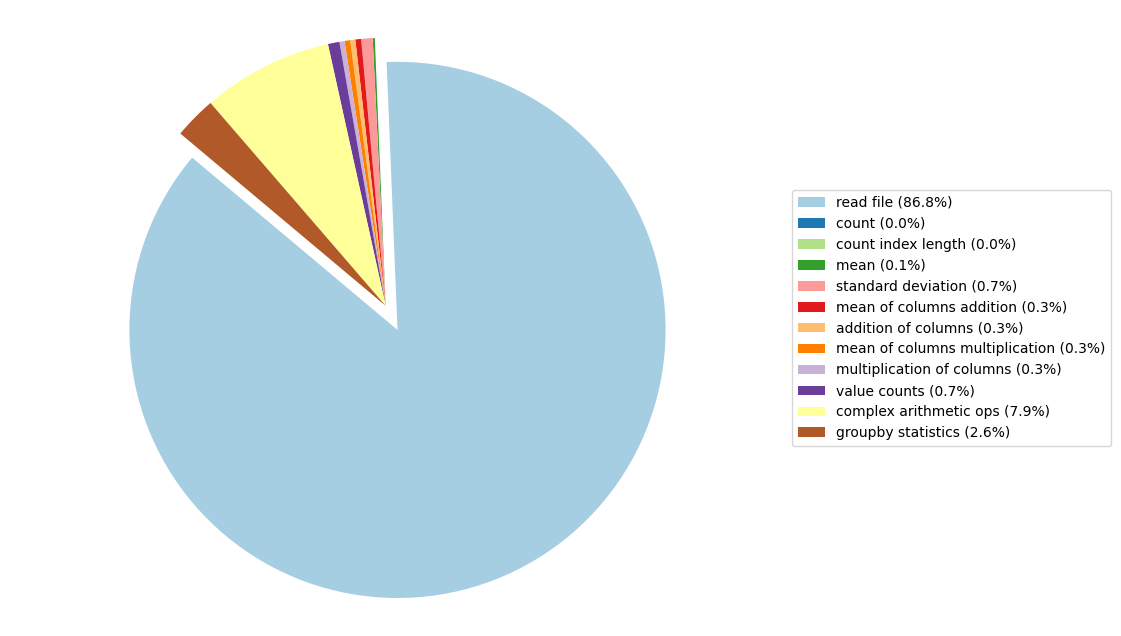

In [15]:
percentages = [f"{(d / sum(results_modin['duration']) * 100):.1f}%" for d in results_modin['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin['task'], percentages)]
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin['duration']))]
plt.figure(figsize=(10, 8))
plt.pie(results_modin['duration'], startangle=140, colors=plt.cm.Paired.colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)
plt.axis('equal')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Análise de Desempenho

A leitura do ficheiro representa a maior fatia do tempo total de execução, sendo o principal gargalo do processo.  
A operação de cálculo aritmético complexo tem algum impacto, mas é bem menor.  
As demais operações contribuem com uma parcela muito pequena do tempo total, tendo impacto quase irrelevante na performance geral.


# Gráfico de Linha para duração de cada operação

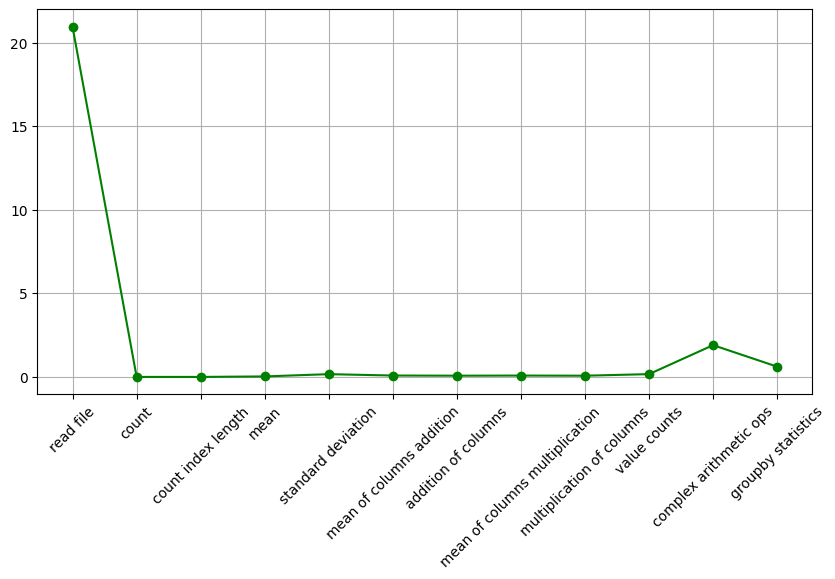

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(results_modin['task'], results_modin['duration'], marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Análise Final de Desempenho

O gráfico de linha reforça que a leitura do ficheiro é a operação mais demorada, destacando-se das restantes.  
Após esta etapa, o tempo de execução das demais operações cai drasticamente e permanece relativamente estável.  
Operações como o cálculo aritmético complexo e estatísticas com `groupby` ainda têm um impacto ligeiramente maior, mas bem inferior ao da leitura.

### Conclusão

As três visualizações confirmam que a leitura do ficheiro é o principal gargalo no processo.  
As outras operações têm tempos de execução baixos, com pouca variação.  
A análise aponta para a necessidade de otimizar a etapa de leitura para melhorar a performance geral.


# Operações com filtro

In [17]:
print(f"DataFrame : {type(modin_data)}")
expr_filter = 'tip_amt >= 1 and tip_amt <= 5'
modin_filtered = modin_data.query(expr_filter)
if not isinstance(modin_filtered, pd.DataFrame):
    modin_filtered = pd.DataFrame(modin_filtered)
modin_benchmarks_filtered = {'duration': [], 'task': []}

DataFrame : <class 'pandas.core.frame.DataFrame'>


In [18]:
benchmark(read_file_parquet, df=None, benchmarks=modin_benchmarks_filtered, name='read file')
benchmark(count, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='count')
benchmark(count_index_length, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='count index length')
benchmark(mean, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='mean')
benchmark(standard_deviation, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='standard deviation')
benchmark(mean_of_sum, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='mean of columns addition')
benchmark(sum_columns, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='addition of columns')
benchmark(mean_of_product, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='mean of columns multiplication')
benchmark(product_columns, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='multiplication of columns')
benchmark(value_counts, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='value counts')
benchmark(complicated_arithmetic_operation, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='complex arithmetic ops')
benchmark(groupby_statistics, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='groupby statistics')

read file took: 20.966774225234985 seconds
count took: 1.5020370483398438e-05 seconds
count index length took: 2.384185791015625e-06 seconds
mean took: 0.009747028350830078 seconds
standard deviation took: 0.043721914291381836 seconds
mean of columns addition took: 0.022001266479492188 seconds
addition of columns took: 0.013028383255004883 seconds
mean of columns multiplication took: 0.015379667282104492 seconds
multiplication of columns took: 0.01301884651184082 seconds
value counts took: 0.043732643127441406 seconds
complex arithmetic ops took: 0.34679126739501953 seconds
groupby statistics took: 0.17151165008544922 seconds


0.17151165008544922

In [19]:
modin_res_filtered = get_results(modin_benchmarks_filtered).drop_duplicates(subset='task').set_index('task')
print(modin_res_filtered)
filename_filter = 'Resultados/modin_filtered1'
modin_res_filtered.to_parquet(filename_filter)
print(f'Dados Guardados em {filename_filter}.')

                                 duration
task                                     
read file                       20.966774
count                            0.000015
count index length               0.000002
mean                             0.009747
standard deviation               0.043722
mean of columns addition         0.022001
addition of columns              0.013028
mean of columns multiplication   0.015380
multiplication of columns        0.013019
value counts                     0.043733
complex arithmetic ops           0.346791
groupby statistics               0.171512
Dados Guardados em Resultados/modin_filtered1.


# cProfile para dados filtrados

In [20]:
modin_benchmarks_filtered_cprofile = {'duration': [], 'task': []}

In [21]:
benchmark_with_cprofile(read_file_parquet, df=None, benchmarks=modin_benchmarks_filtered_cprofile, name='read file')
benchmark_with_cprofile(count, df=modin_filtered, benchmarks=modin_benchmarks_filtered_cprofile, name='count')
benchmark_with_cprofile(count_index_length, df=modin_filtered, benchmarks=modin_benchmarks_filtered_cprofile, name='count index length')
benchmark_with_cprofile(mean, df=modin_filtered, benchmarks=modin_benchmarks_filtered_cprofile, name='mean')
benchmark_with_cprofile(standard_deviation, df=modin_filtered, benchmarks=modin_benchmarks_filtered_cprofile, name='standard deviation')
benchmark_with_cprofile(mean_of_sum, df=modin_filtered, benchmarks=modin_benchmarks_filtered_cprofile, name='mean of columns addition')
benchmark_with_cprofile(sum_columns, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='addition of columns')
benchmark_with_cprofile(mean_of_product, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='mean of columns multiplication')
benchmark_with_cprofile(product_columns, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='multiplication of columns')
benchmark_with_cprofile(value_counts, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='value counts')
benchmark_with_cprofile(complicated_arithmetic_operation, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='complex arithmetic ops')
benchmark_with_cprofile(groupby_statistics, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='groupby statistics')

read file took: 21.111013889312744 seconds
         987 function calls (982 primitive calls) in 21.112 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   21.111   21.111 631048046.py:4(read_file_parquet)
        1    0.110    0.110   21.111   21.111 parquet.py:498(read_parquet)
        1    0.000    0.000   21.000   21.000 parquet.py:239(read)
        1   11.489   11.489   11.490   11.490 pandas_compat.py:782(table_to_dataframe)
        1    0.000    0.000    9.510    9.510 core.py:1764(read_table)
        1    9.509    9.509    9.509    9.509 core.py:1410(read)
        1    0.000    0.000    0.001    0.001 {built-in method builtins.print}
        2    0.000    0.000    0.001    0.000 iostream.py:655(write)
        2    0.000    0.000    0.001    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.001    0.001 iostream.py:259(schedule)
        1    0.001    0.001    0.001    

0.16364598274230957

# Gráfico de Barras

In [22]:
results_modin_filtered = pd.DataFrame.from_dict(modin_benchmarks_filtered_cprofile)

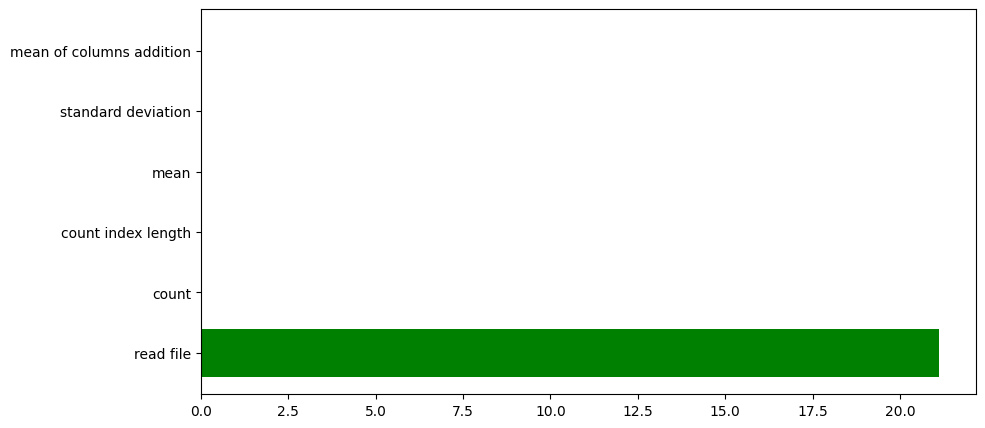

In [23]:
plt.figure(figsize=(10, 5))
plt.barh(results_modin_filtered['task'], results_modin_filtered['duration'], color='green')
plt.show()

### Análise de Desempenho

A leitura do ficheiro é, de longe, a operação mais demorada, destacando-se claramente das restantes.  
A maioria das operações restantes tem tempos de execução muito reduzidos, praticamente desprezáveis em comparação com a leitura do ficheiro.


# Gráfico de Pizza

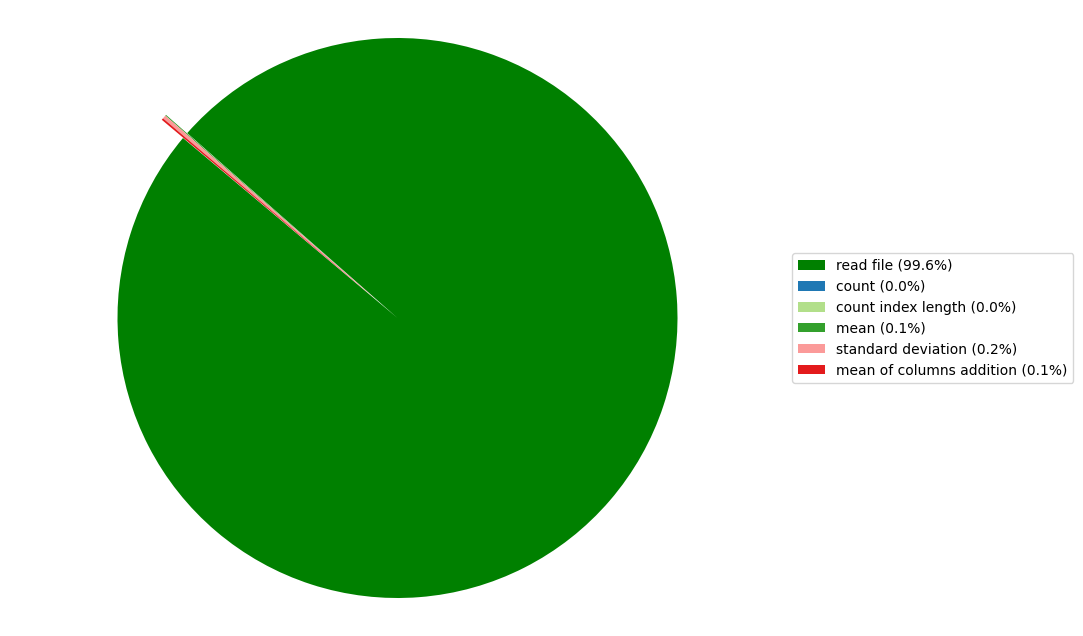

In [24]:
percentages = [f"{(d / sum(results_modin_filtered['duration']) * 100):.1f}%" for d in results_modin_filtered['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin_filtered['task'], percentages)]
colors = ['green' if task == 'read file' else color for task, color in zip(results_modin_filtered['task'], plt.cm.Paired.colors)]
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin_filtered['duration']))]
plt.figure(figsize=(10, 8))
plt.pie(results_modin_filtered['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)
plt.axis('equal')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Análise de Desempenho

A leitura do ficheiro consome quase todo o tempo de execução.  


# Gráfico de Linha

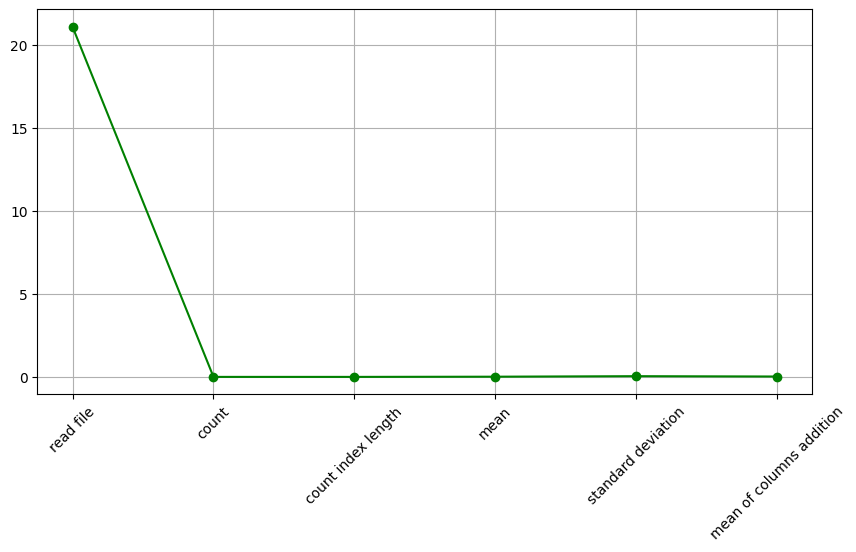

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(results_modin_filtered['task'], results_modin_filtered['duration'], marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Análise e Conclusão Geral

O gráfico de linha confirma que a leitura do ficheiro é a operação mais lenta, destacando-se claramente das restantes.  
Após essa etapa, há uma queda acentuada no tempo de execução das outras operações, que apresentam durações muito semelhantes entre si.  



# Operações com filtro e cache


In [26]:
if isinstance(modin_filtered, pd.DataFrame):
    print(modin_filtered.head())
    dask_df = modin_filtered
else:
    raise TypeError("error")
dask_df = dd.from_pandas(dask_df, npartitions=10)
dask_df = client.persist(dask_df)
modin_cache = dask_df
modin_benchmarks_cache = {'duration': [], 'task': []}

   vendor_name trip_pickup_datetime trip_dropoff_datetime  passenger_count  \
0          VTS  2009-12-17 07:35:00   2009-12-17 07:40:00                1   
3          VTS  2009-12-14 21:24:00   2009-12-14 21:33:00                2   
18         VTS  2009-12-14 20:53:00   2009-12-14 21:05:00                1   
19         VTS  2009-12-16 01:31:00   2009-12-16 01:47:00                5   
21         VTS  2009-12-21 10:54:00   2009-12-21 11:18:00                1   

    trip_distance  start_lon  start_lat  rate_code  store_and_forward  \
0            0.11 -73.987928  40.737885        NaN                NaN   
3            1.66 -73.983985  40.754645        NaN                NaN   
18           2.31 -73.984372  40.759978        NaN                NaN   
19           5.03 -74.003327  40.751415        NaN                NaN   
21           2.51 -73.972892  40.782560        NaN                NaN   

      end_lon    end_lat payment_type  fare_amt  surcharge  mta_tax  tip_amt  \
0  -73.99033

This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.


In [27]:
benchmark(read_file_parquet, df=None, benchmarks=modin_benchmarks_cache, name='read file')
benchmark(count, df=modin_cache, benchmarks=modin_benchmarks_cache, name='count')
benchmark(count_index_length, df=modin_cache, benchmarks=modin_benchmarks_cache, name='count index length')
benchmark(mean, df=modin_cache, benchmarks=modin_benchmarks_cache, name='mean')
benchmark(standard_deviation, df=modin_cache, benchmarks=modin_benchmarks_cache, name='standard deviation')
benchmark(mean_of_sum, df=modin_cache, benchmarks=modin_benchmarks_cache, name='mean of columns addition')
benchmark(sum_columns, df=modin_cache, benchmarks=modin_benchmarks_cache, name='addition of columns')
benchmark(mean_of_product, df=modin_cache, benchmarks=modin_benchmarks_cache, name='mean of columns multiplication')
benchmark(product_columns, df=modin_cache, benchmarks=modin_benchmarks_cache, name='multiplication of columns')
benchmark(value_counts, df=modin_cache, benchmarks=modin_benchmarks_cache, name='value counts')
benchmark(complicated_arithmetic_operation, df=modin_cache, benchmarks=modin_benchmarks_cache, name='complex arithmetic ops')
benchmark(groupby_statistics, df=modin_cache, benchmarks=modin_benchmarks_cache, name='groupby statistics')

read file took: 21.43735122680664 seconds
count took: 0.7233216762542725 seconds
count index length took: 0.0649116039276123 seconds
mean took: 0.0016052722930908203 seconds
standard deviation took: 0.004870176315307617 seconds
mean of columns addition took: 0.015379190444946289 seconds
addition of columns took: 0.0017719268798828125 seconds
mean of columns multiplication took: 0.0014886856079101562 seconds
multiplication of columns took: 0.0019028186798095703 seconds
value counts took: 0.0006489753723144531 seconds
complex arithmetic ops took: 0.034667253494262695 seconds
groupby statistics took: 0.08709049224853516 seconds


0.08709049224853516

In [28]:
modin_res_cache = get_results(modin_benchmarks_cache).drop_duplicates(subset='task').set_index('task')
print(modin_res_cache)
filename_cache = 'Resultados/modin_cache1'
modin_res_cache.to_parquet(filename_cache)

print(f'Dados Guardados em {filename_cache}.')

                                 duration
task                                     
read file                       21.437351
count                            0.723322
count index length               0.064912
mean                             0.001605
standard deviation               0.004870
mean of columns addition         0.015379
addition of columns              0.001772
mean of columns multiplication   0.001489
multiplication of columns        0.001903
value counts                     0.000649
complex arithmetic ops           0.034667
groupby statistics               0.087090
Dados Guardados em Resultados/modin_cache1.


# cProfile em dados filtrados com cache

In [29]:
modin_benchmarks_cache_cprofile = {'duration': [], 'task': []}

In [30]:
benchmark_with_cprofile(read_file_parquet, df=None, benchmarks=modin_benchmarks_cache_cprofile, name='read file')
benchmark_with_cprofile(count, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='count')
benchmark_with_cprofile(count_index_length, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='count index length')
benchmark_with_cprofile(mean, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='mean')
benchmark_with_cprofile(standard_deviation, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='standard deviation')
benchmark_with_cprofile(mean_of_sum, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='mean of columns addition')
benchmark_with_cprofile(sum_columns, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='addition of columns')
benchmark_with_cprofile(mean_of_product, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='mean of columns multiplication')
benchmark_with_cprofile(product_columns, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='multiplication of columns')
benchmark_with_cprofile(value_counts, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='value counts')
benchmark_with_cprofile(complicated_arithmetic_operation, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='complex arithmetic ops')
benchmark_with_cprofile(groupby_statistics, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='groupby statistics')

read file took: 20.961505651474 seconds
         987 function calls (982 primitive calls) in 20.963 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   20.961   20.961 631048046.py:4(read_file_parquet)
        1    0.115    0.115   20.961   20.961 parquet.py:498(read_parquet)
        1    0.000    0.000   20.846   20.846 parquet.py:239(read)
        1   11.378   11.378   11.379   11.379 pandas_compat.py:782(table_to_dataframe)
        1    0.000    0.000    9.466    9.466 core.py:1764(read_table)
        1    9.465    9.465    9.465    9.465 core.py:1410(read)
        1    0.000    0.000    0.001    0.001 {built-in method builtins.print}
        2    0.000    0.000    0.001    0.001 iostream.py:655(write)
        2    0.000    0.000    0.001    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.001    0.001 iostream.py:259(schedule)
        1    0.001    0.001    0.001    0.0

0.03885197639465332

In [31]:
results_modin_cache = pd.DataFrame.from_dict(modin_benchmarks_cache_cprofile)

# Gráfico de Barras Horizontais

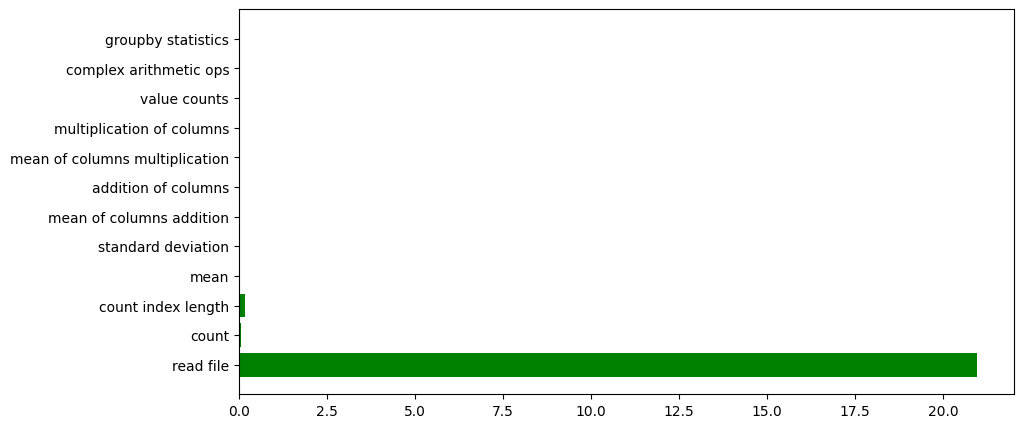

In [32]:
plt.figure(figsize=(10, 5))
plt.barh(results_modin_cache['task'], results_modin_cache['duration'], color='green')
plt.show()

### Análise

A leitura do ficheiro destaca-se como a operação mais demorada de todo o processo.  


# Gráfico de Pizza

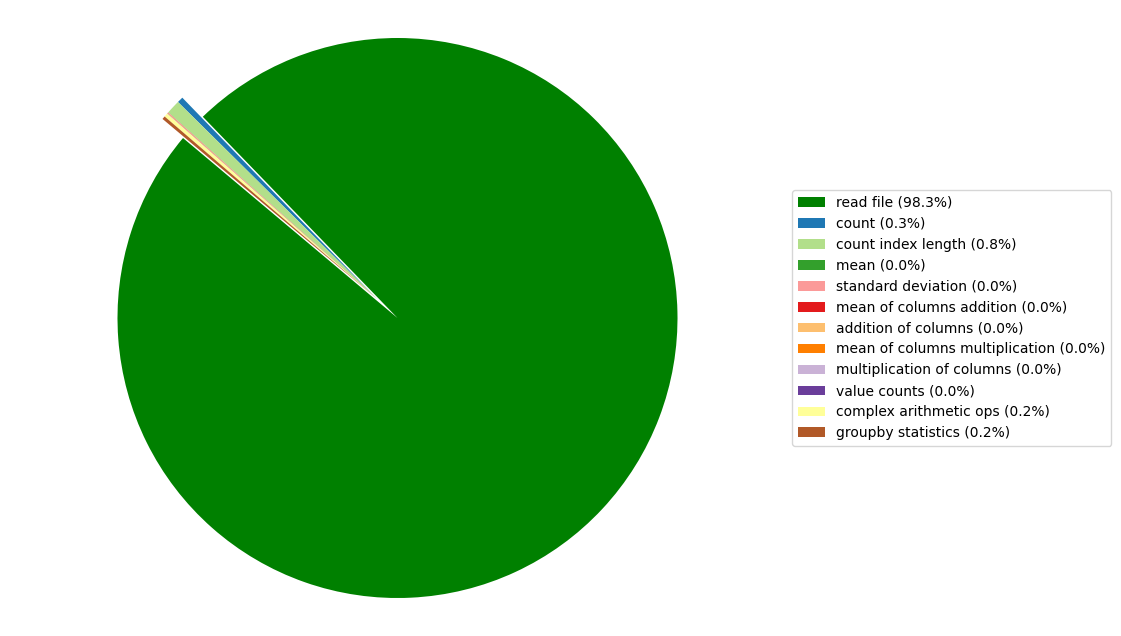

In [33]:
percentages = [f"{(d / sum(results_modin_cache['duration']) * 100):.1f}%" for d in results_modin_cache['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin_cache['task'], percentages)]
colors = ['green' if task == 'read file' else color for task, color in zip(results_modin_cache['task'], plt.cm.Paired.colors)]
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin_cache['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_modin_cache['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)
plt.axis('equal')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Análise

A leitura do ficheiro é a etapa que mais consome tempo, representando praticamente todo o tempo de processamento.  
As restantes tarefas têm impacto mínimo, sendo a contagem a mais relevante entre elas, ainda que com peso reduzido.


# Gráfico de linha

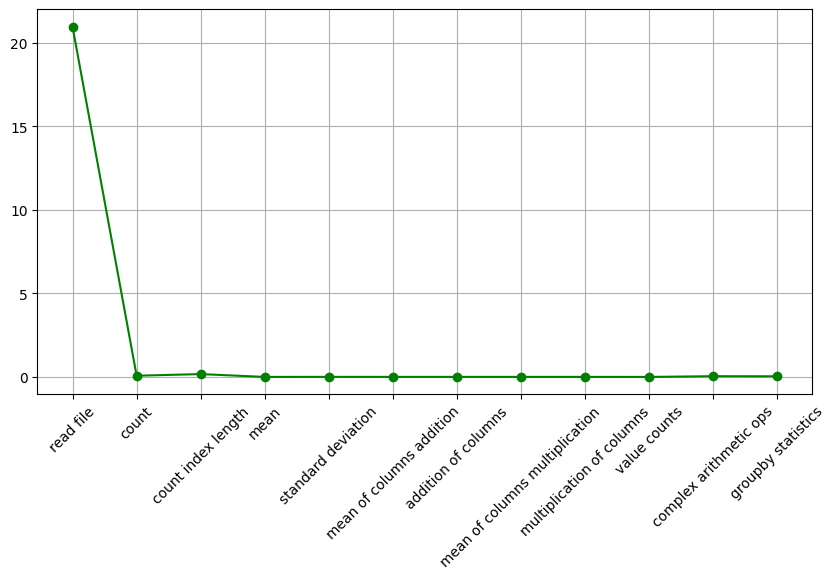

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(results_modin_cache['task'], results_modin_cache['duration'], marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Análise e Conclusão

A leitura do ficheiro é, de longe, a tarefa mais demorada, sendo o principal gargalo do processamento.  
As demais operações, como aritmética e contagem, são muito rápidas e pouco impactam o tempo total.  
Ferramentas como Modin + Dask mostram bom desempenho após a leitura, sugerindo que otimizações devem focar na etapa inicial de carregamento dos dados.


In [35]:
client.restart()

# Joblib

In [36]:
import pandas as pd
import numpy as np
import time
from joblib import dump, load
import cProfile
import matplotlib.pyplot as plt
from io import StringIO
import pstats
parquet_file = 'Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet'
data = pd.read_parquet(parquet_file)
print(data.columns)
data = data.rename(columns=str.lower)

Index(['vendor_name', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime',
       'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat',
       'Rate_Code', 'store_and_forward', 'End_Lon', 'End_Lat', 'Payment_Type',
       'Fare_Amt', 'surcharge', 'mta_tax', 'Tip_Amt', 'Tolls_Amt',
       'Total_Amt'],
      dtype='object')


In [37]:
def get_results(benchmarks):
    return pd.DataFrame.from_dict(benchmarks)

def read_file_parquet(df=None):
    return pd.read_parquet(parquet_file)

def count(df):
    return len(df)

def count_index_length(df):
    return len(df.index)

def mean(df):
    return df['fare_amt'].mean()

def standard_deviation(df):
    return df['fare_amt'].std()

def mean_of_sum(df):
    return (df['fare_amt'] + df['tip_amt']).mean()

def sum_columns(df):
    return (df['fare_amt'] + df['tip_amt']).sum()

def mean_of_product(df):
    return (df['fare_amt'] * df['tip_amt']).mean()

def product_columns(df):
    return (df['fare_amt'] * df['tip_amt']).sum()

def value_counts(df):
    return df['fare_amt'].value_counts()

def complicated_arithmetic_operation(df):
    theta_1 = df['start_lon']
    phi_1 = df['start_lat']
    theta_2 = df['end_lon']
    phi_2 = df['end_lat']
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180)
           * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1 - temp))
    return ret.mean()

def groupby_statistics(df):
    return df.groupby(by='passenger_count').agg({
        'fare_amt': ['mean', 'std'], 
        'tip_amt': ['mean', 'std']
    })

def join_count(df, other):
    return len(df.merge(other, left_index=True, right_index=True))

def join_data(df, other):
    return df.merge(other, left_index=True, right_index=True)

def benchmark(f, df, benchmarks, name, **kwargs):
    start_time = time.time()
    ret = f(df, **kwargs)
    duration = time.time() - start_time
    benchmarks['duration'].append(duration)
    benchmarks['task'].append(name)
    print(f"{name} took: {duration} seconds")
    return duration

def execute_benchmarks(data, benchmarks):
    benchmark(count, data, benchmarks, 'count')
    benchmark(count_index_length, data, benchmarks, 'count_index_length')
    benchmark(mean, data, benchmarks, 'mean')
    benchmark(standard_deviation, data, benchmarks, 'standard_deviation')
    benchmark(mean_of_sum, data, benchmarks, 'mean_of_sum')
    benchmark(sum_columns, data, benchmarks, 'sum_columns')
    benchmark(mean_of_product, data, benchmarks, 'mean_of_product')
    benchmark(product_columns, data, benchmarks, 'product_columns')
    benchmark(value_counts, data, benchmarks, 'value_counts')
    benchmark(complicated_arithmetic_operation, data, benchmarks, 'complicated_arithmetic_operation')
    benchmark(groupby_statistics, data, benchmarks, 'groupby_statistics')
    other_data = data.copy()
    benchmark(join_count, data, benchmarks, 'join_count', other=other_data)
    benchmark(join_data, data, benchmarks, 'join_data', other=other_data)

### Processo de Benchmarking

- Inicializaram-se dicionários para guardar a duração das operações e suas tarefas associadas.
- Realizaram-se benchmarks com o conjunto de dados completo, registrando os tempos.
- Aplicou-se filtro para selecionar registros com gorjetas entre 1 e 5, criando um subconjunto filtrado.
- Executaram-se benchmarks no conjunto filtrado, armazenando as durações.
- Os dados filtrados foram salvos em disco com Joblib e depois recarregados para simular cache.
- Realizaram-se benchmarks no conjunto em cache, registrando os tempos correspondentes.


In [38]:
joblib_benchmarks_standard_cprofile = {'duration': [], 'task': []}
execute_benchmarks(data, joblib_benchmarks_standard_cprofile)

count took: 1.3828277587890625e-05 seconds
count_index_length took: 3.814697265625e-06 seconds
mean took: 0.03423500061035156 seconds
standard_deviation took: 0.16907262802124023 seconds
mean_of_sum took: 0.08607149124145508 seconds
sum_columns took: 0.07634139060974121 seconds
mean_of_product took: 0.08475518226623535 seconds
product_columns took: 0.07600855827331543 seconds
value_counts took: 0.17026185989379883 seconds
complicated_arithmetic_operation took: 1.920105218887329 seconds
groupby_statistics took: 0.6150987148284912 seconds
join_count took: 4.411859512329102 seconds
join_data took: 3.019374132156372 seconds


In [39]:
joblib_benchmarks = {'duration': [], 'task': []}
execute_benchmarks(data, joblib_benchmarks)
expr_filter = (data['tip_amt'] >= 1) & (data['tip_amt'] <= 5)
filtered_data = data[expr_filter]
joblib_benchmarks_filtered = {'duration': [], 'task': []}
execute_benchmarks(filtered_data, joblib_benchmarks_filtered)
joblib_benchmarks_cache = {'duration': [], 'task': []}
dump(filtered_data, 'filtered_data.pkl')
cached_data = load('filtered_data.pkl')
execute_benchmarks(cached_data, joblib_benchmarks_cache)

count took: 1.239776611328125e-05 seconds
count_index_length took: 2.1457672119140625e-06 seconds
mean took: 0.03073406219482422 seconds
standard_deviation took: 0.1674480438232422 seconds
mean_of_sum took: 0.0818939208984375 seconds
sum_columns took: 0.0735325813293457 seconds
mean_of_product took: 0.08254623413085938 seconds
product_columns took: 0.07352590560913086 seconds
value_counts took: 0.16934847831726074 seconds
complicated_arithmetic_operation took: 1.9248456954956055 seconds
groupby_statistics took: 0.6188654899597168 seconds
join_count took: 4.1913158893585205 seconds
join_data took: 3.039073944091797 seconds
count took: 3.337860107421875e-06 seconds
count_index_length took: 1.6689300537109375e-06 seconds
mean took: 0.007899761199951172 seconds
standard_deviation took: 0.034911394119262695 seconds
mean_of_sum took: 0.01548457145690918 seconds
sum_columns took: 0.013118505477905273 seconds
mean_of_product took: 0.015072345733642578 seconds
product_columns took: 0.0128610134

### Conclusão

Os resultados mostram que filtrar os dados e usar cache melhora significativamente o tempo de execução das operações, indicando que essas estratégias otimizam o desempenho na análise de dados.


# Guardar Resultados

In [40]:
joblib_res_temp = get_results(joblib_benchmarks).drop_duplicates(subset='task').set_index('task')
print(joblib_res_temp)
filename = 'Resultados/joblib_standard1'
joblib_res_temp.to_parquet(filename)
print(f'Guardado em {filename}.')

                                  duration
task                                      
count                             0.000012
count_index_length                0.000002
mean                              0.030734
standard_deviation                0.167448
mean_of_sum                       0.081894
sum_columns                       0.073533
mean_of_product                   0.082546
product_columns                   0.073526
value_counts                      0.169348
complicated_arithmetic_operation  1.924846
groupby_statistics                0.618865
join_count                        4.191316
join_data                         3.039074
Guardado em Resultados/joblib_standard1.


In [41]:
joblib_res_filtered = get_results(joblib_benchmarks_filtered).drop_duplicates(subset='task').set_index('task')
print(joblib_res_filtered)
filename_filtered = 'Resultados/joblib_filtered1'
joblib_res_filtered.to_parquet(filename_filtered)
print(f'Guardado em {filename_filtered}.')

                                  duration
task                                      
count                             0.000003
count_index_length                0.000002
mean                              0.007900
standard_deviation                0.034911
mean_of_sum                       0.015485
sum_columns                       0.013119
mean_of_product                   0.015072
product_columns                   0.012861
value_counts                      0.042573
complicated_arithmetic_operation  0.351354
groupby_statistics                0.146597
join_count                        1.274371
join_data                         0.805216
Guardado em Resultados/joblib_filtered1.


In [42]:
joblib_res_cache = get_results(joblib_benchmarks_cache).drop_duplicates(subset='task').set_index('task')
print(joblib_res_cache)
filename_cache = 'Resultados/joblib_cache1'
joblib_res_cache.to_parquet(filename_cache)
print(f'Guardado em {filename_cache}.')

                                  duration
task                                      
count                             0.000006
count_index_length                0.000002
mean                              0.007941
standard_deviation                0.042278
mean_of_sum                       0.020459
sum_columns                       0.013000
mean_of_product                   0.014976
product_columns                   0.012778
value_counts                      0.044040
complicated_arithmetic_operation  0.354036
groupby_statistics                0.162462
join_count                        0.905440
join_data                         0.706451
Guardado em Resultados/joblib_cache1.


# cProfile

In [43]:
import cProfile
import pstats
import io

def benchmark_cprofile(f, df, benchmarks, name, **kwargs):
    pr = cProfile.Profile()
    pr.enable()
    
    start_time = time.time()
    ret = f(df, **kwargs)
    duration = time.time() - start_time
    
    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats(pstats.SortKey.CUMULATIVE)
    ps.print_stats()
    with open(f'{name}_profile.txt', 'w') as f_out:
        f_out.write(s.getvalue())
    
    benchmarks['duration'].append(duration)
    benchmarks['task'].append(name)
    print(f"{name} took: {duration} seconds")
    return duration

def execute_benchmarks(data, benchmarks):
    benchmark_cprofile(count, data, benchmarks, 'count')
    benchmark_cprofile(count_index_length, data, benchmarks, 'count_index_length')
    benchmark_cprofile(mean, data, benchmarks, 'mean')
    benchmark_cprofile(standard_deviation, data, benchmarks, 'standard_deviation')
    benchmark_cprofile(mean_of_sum, data, benchmarks, 'mean_of_sum')
    benchmark_cprofile(sum_columns, data, benchmarks, 'sum_columns')
    benchmark_cprofile(mean_of_product, data, benchmarks, 'mean_of_product')
    benchmark_cprofile(product_columns, data, benchmarks, 'product_columns')
    benchmark_cprofile(value_counts, data, benchmarks, 'value_counts')
    benchmark_cprofile(complicated_arithmetic_operation, data, benchmarks, 'complicated_arithmetic_operation')
    benchmark_cprofile(groupby_statistics, data, benchmarks, 'groupby_statistics')
    other_data = data.copy()
    benchmark_cprofile(join_count, data, benchmarks, 'join_count', other=other_data)
    benchmark_cprofile(join_data, data, benchmarks, 'join_data', other=other_data)

In [44]:
joblib_benchmarks_standard_cprofile = {'duration': [], 'task': []}
execute_benchmarks(data, joblib_benchmarks_standard_cprofile)

count took: 1.811981201171875e-05 seconds
count_index_length took: 1.2159347534179688e-05 seconds
mean took: 0.03125953674316406 seconds
standard_deviation took: 0.16949176788330078 seconds
mean_of_sum took: 0.08425593376159668 seconds
sum_columns took: 0.07495546340942383 seconds
mean_of_product took: 0.08522534370422363 seconds
product_columns took: 0.07694339752197266 seconds
value_counts took: 0.168501615524292 seconds
complicated_arithmetic_operation took: 1.9030957221984863 seconds
groupby_statistics took: 0.6213104724884033 seconds
join_count took: 4.294339179992676 seconds
join_data took: 3.071897029876709 seconds


In [45]:
joblib_benchmarks_standard_cprofile = {'duration': [], 'task': []}
execute_benchmarks(data, joblib_benchmarks_standard_cprofile)

count took: 1.6689300537109375e-05 seconds
count_index_length took: 1.2159347534179688e-05 seconds
mean took: 0.032868385314941406 seconds
standard_deviation took: 0.1705927848815918 seconds
mean_of_sum took: 0.08784985542297363 seconds
sum_columns took: 0.07874798774719238 seconds
mean_of_product took: 0.08749651908874512 seconds
product_columns took: 0.07653450965881348 seconds
value_counts took: 0.16947317123413086 seconds
complicated_arithmetic_operation took: 1.939201831817627 seconds
groupby_statistics took: 0.6358716487884521 seconds
join_count took: 4.151718378067017 seconds
join_data took: 3.0090205669403076 seconds


In [46]:
results_joblib = pd.DataFrame.from_dict(joblib_benchmarks_standard_cprofile)

# Gráfico de Barras Horizontais

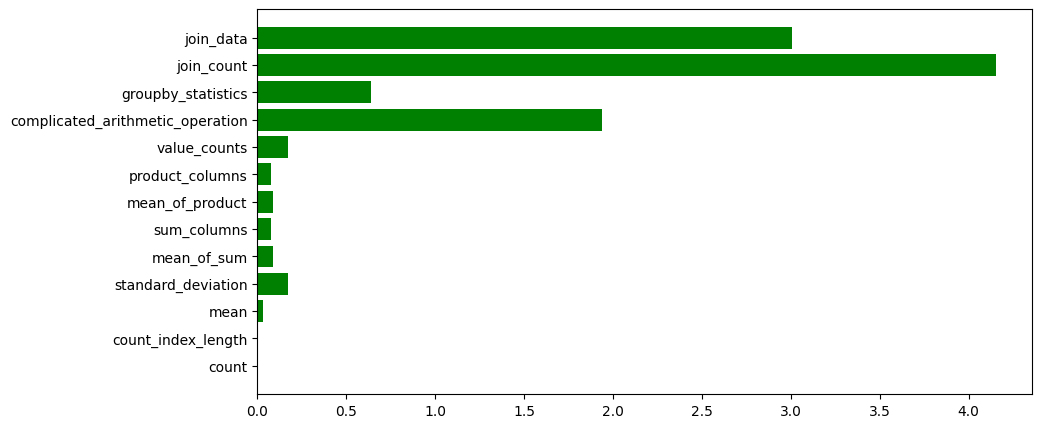

In [47]:
plt.figure(figsize=(10, 5))
plt.barh(results_joblib['task'], results_joblib['duration'], color='green')
plt.show()

### Resultados

As tarefas que mais consomem tempo são join_data, join_count e complicated_arithmetic_operation, enquanto as que consomem menos tempo são mean, product e sim demoram menos.


# Grafo Pizza

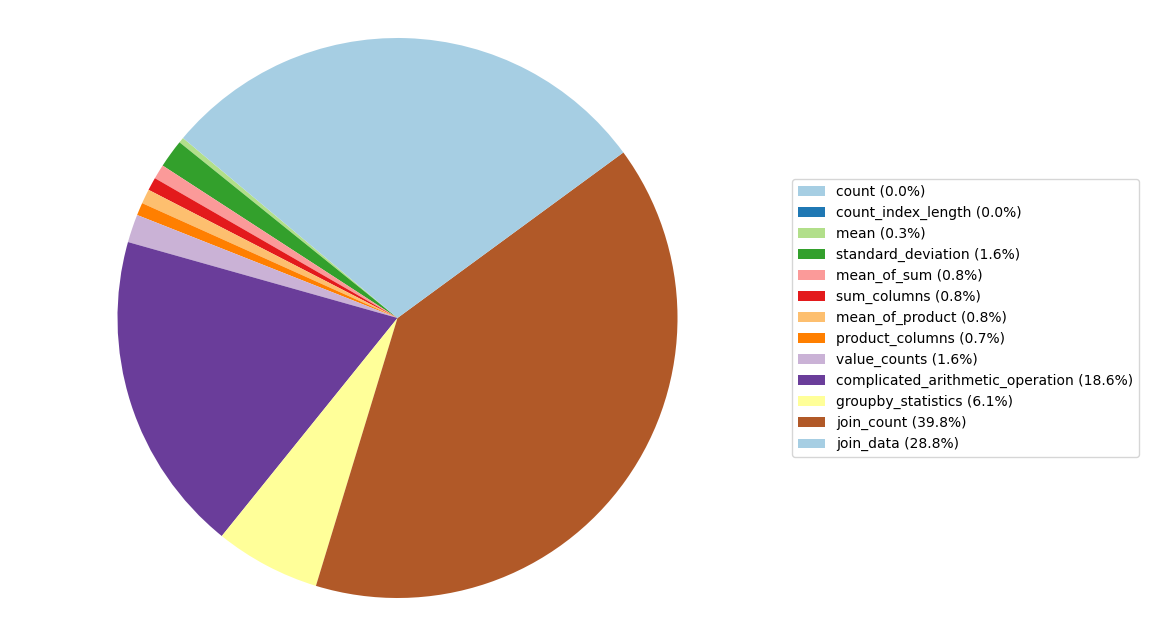

In [48]:
percentages = [f"{(d / sum(results_joblib['duration']) * 100):.1f}%" for d in results_joblib['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_joblib['task'], percentages)]
colors = ['green' if task == 'read file' else color for task, color in zip(results_joblib['task'], plt.cm.Paired.colors)]
explode = [0.1 if i == 0 else 0 for i in range(len(results_joblib['duration']))]
plt.figure(figsize=(10, 8))
plt.pie(results_joblib['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)
plt.axis('equal')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Gráfico de Linha

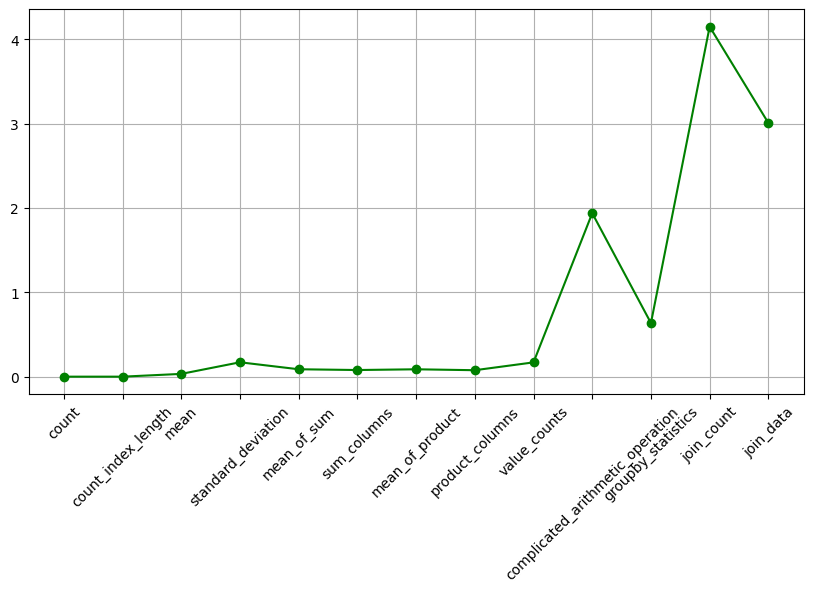

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(results_joblib['task'], results_joblib['duration'], marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Conclusões para operações padrão

- Operações de junção (join_data, join_count) e a operação aritmética complexa (complicated_arithmetic_operation) consomem mais tempo, sendo os principais pontos para otimização.  
- Operações simples como contagem (count), média (mean) e soma de colunas (sum_columns) são rápidas e eficientes, sem necessidade imediata de otimização.


# Operações em dados filtrados

In [50]:
expr_filter = (data['tip_amt'] >= 1) & (data['tip_amt'] <= 5)
filtered_data = data[expr_filter]
joblib_benchmarks_filtered_cprofile = {'duration': [], 'task': []}
execute_benchmarks(filtered_data, joblib_benchmarks_filtered_cprofile)

count took: 2.0265579223632812e-05 seconds
count_index_length took: 1.2874603271484375e-05 seconds
mean took: 0.008979558944702148 seconds
standard_deviation took: 0.029541492462158203 seconds
mean_of_sum took: 0.016912460327148438 seconds
sum_columns took: 0.014251232147216797 seconds
mean_of_product took: 0.01639389991760254 seconds
product_columns took: 0.014470338821411133 seconds
value_counts took: 0.03963303565979004 seconds
complicated_arithmetic_operation took: 0.32377147674560547 seconds
groupby_statistics took: 0.14705467224121094 seconds
join_count took: 1.0786783695220947 seconds
join_data took: 0.775040864944458 seconds


In [51]:
results_joblib_filtered = pd.DataFrame.from_dict(joblib_benchmarks_filtered_cprofile)

# Gráfico de Barras Horizontais em dados filtrados

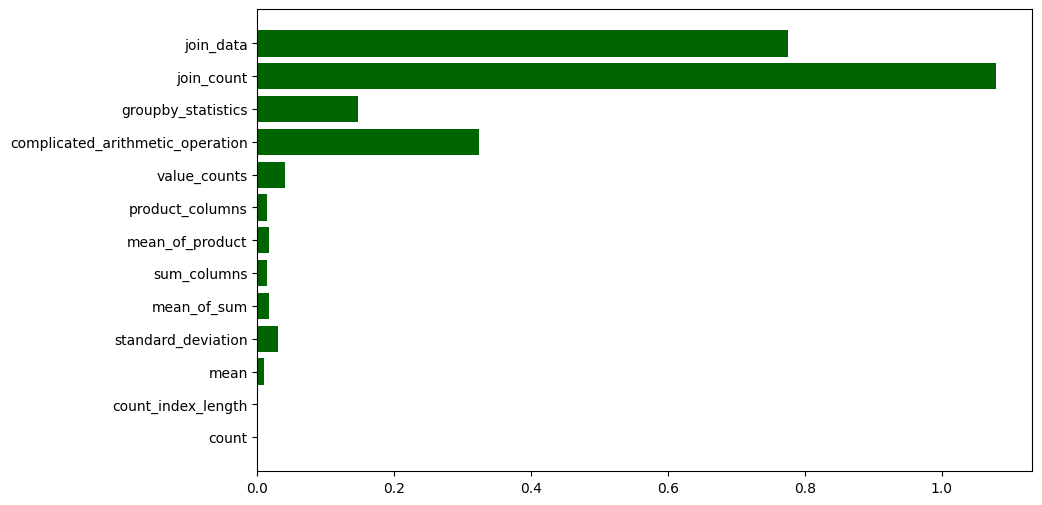

In [52]:
plt.figure(figsize=(10, 6))
plt.barh(results_joblib_filtered['task'], results_joblib_filtered['duration'], color='darkgreen')
plt.show()

### Resultados

- As tarefas que mais consomem tempo são join_data, join_count e complicated_arithmetic_operation, enquanto as que consomem menos tempo são mean e product_columns, similar ao que ocorre nas operações padrão.  
- Para os dados filtrados, os tempos de execução são muito menores, com as tarefas mais demoradas apresentando uma duração bastante reduzida.


# Gráfico Pizza em dados filtrados

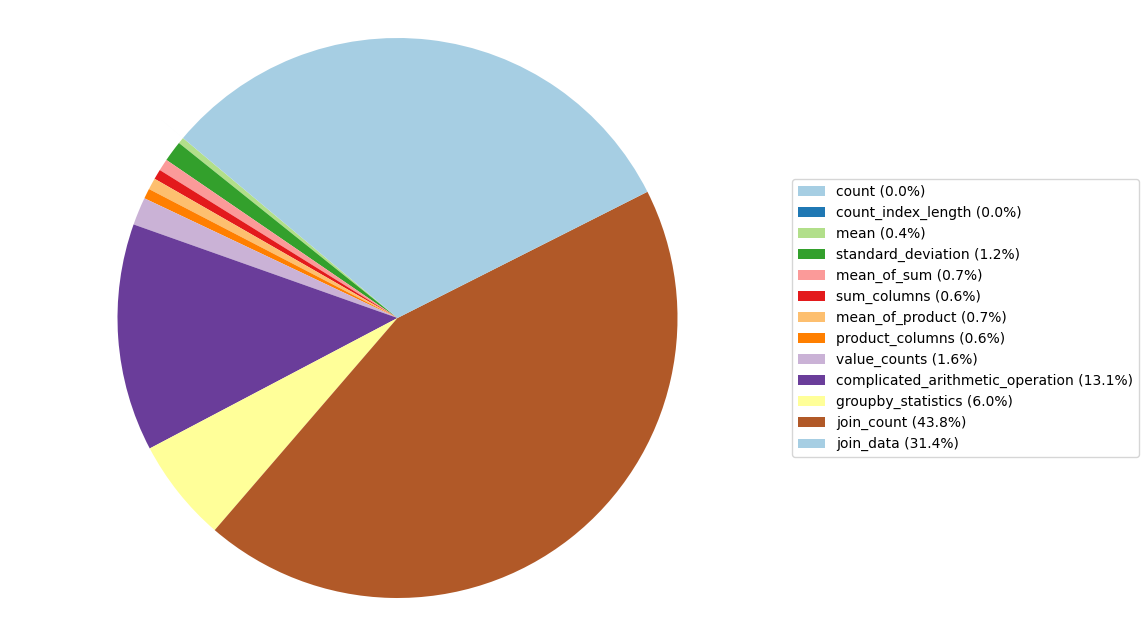

In [53]:
percentages = [f"{(d / sum(results_joblib_filtered['duration']) * 100):.1f}%" for d in results_joblib_filtered['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_joblib_filtered['task'], percentages)]
colors = ['green' if task == 'read file' else color for task, color in zip(results_joblib_filtered['task'], plt.cm.Paired.colors)]
explode = [0.1 if i == 0 else 0 for i in range(len(results_joblib_filtered['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_joblib_filtered['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)
plt.axis('equal')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Análise das Operações

- As operações de junção e as aritméticas complexas são as que mais consomem tempo, com variações no consumo em relação às operações padrão: join_datacom teve uma redução, join_count aumentou, e complicated_arithmetic_operation diminuiu.
- As operações de contagem, como count e count_index_length, são as que consomem menos tempo, sendo bastante eficientes.


# Gráfico de linhas em dados filtrados

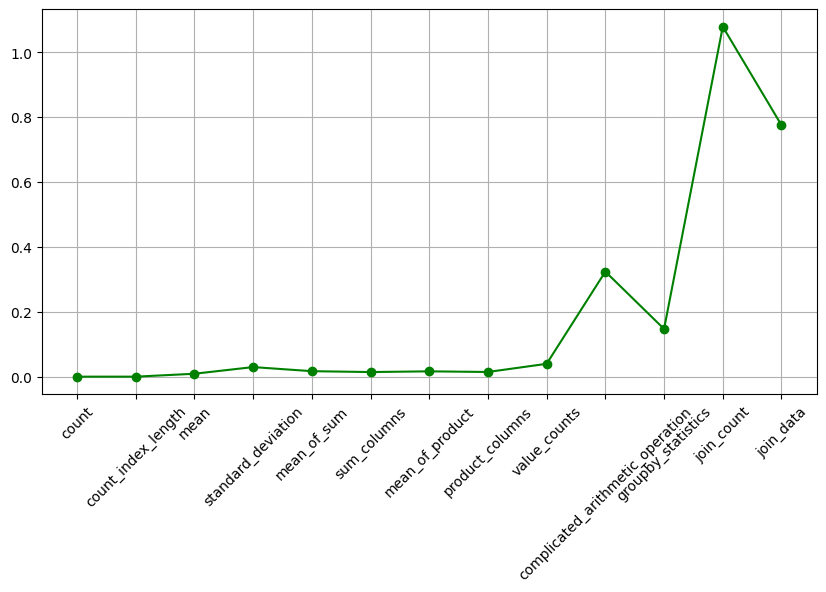

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(results_joblib_filtered['task'], results_joblib_filtered['duration'], marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Conclusões para operações de filtragem

- As operações que mais consomem tempo são as junções (join_data, join_count) e a operação aritmética complexa (complicated_arithmetic_operation), que devem ser o foco da otimização.
- Operações simples, como contagem, média e soma de colunas, têm tempos muito baixos, mostrando boa eficiência e não exigindo otimização imediata.
- Comparado às operações padrão, as durações são menores, indicando melhor desempenho após a filtragem.


# Operações em dados filtrados com cache

In [55]:
joblib_benchmarks_cache_cprofile = {'duration': [], 'task': []}
dump(filtered_data, 'filtered_data.pkl')
cached_data = load('filtered_data.pkl')
execute_benchmarks(cached_data, joblib_benchmarks_cache_cprofile)

count took: 2.002716064453125e-05 seconds
count_index_length took: 1.1920928955078125e-05 seconds
mean took: 0.008331537246704102 seconds
standard_deviation took: 0.029896259307861328 seconds
mean_of_sum took: 0.015948772430419922 seconds
sum_columns took: 0.013330459594726562 seconds
mean_of_product took: 0.015136480331420898 seconds
product_columns took: 0.013229608535766602 seconds
value_counts took: 0.04196977615356445 seconds
complicated_arithmetic_operation took: 0.32869696617126465 seconds
groupby_statistics took: 0.1468973159790039 seconds
join_count took: 0.8831386566162109 seconds
join_data took: 0.6829991340637207 seconds


In [56]:
results_joblib_cache = pd.DataFrame.from_dict(joblib_benchmarks_cache_cprofile)

# Gráfico de Barras Horizontais em dados filtrados com cache

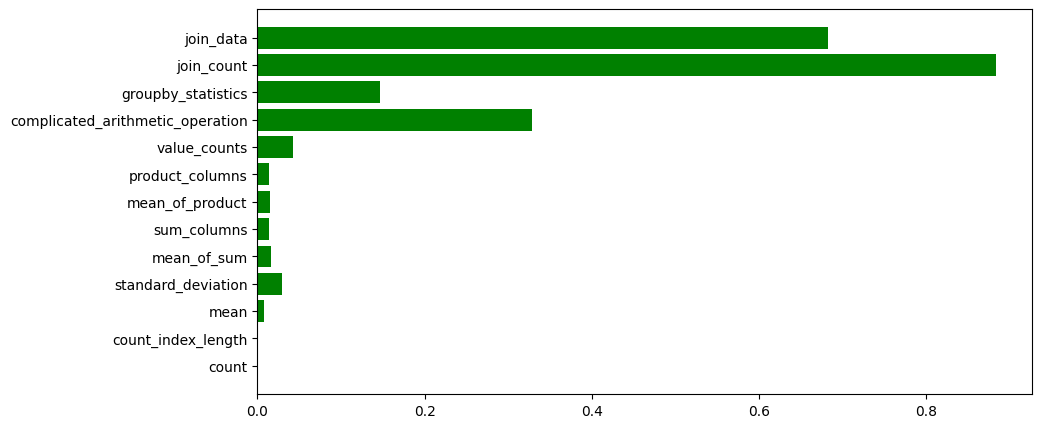

In [57]:
plt.figure(figsize=(10, 5))
plt.barh(results_joblib_cache['task'], results_joblib_cache['duration'], color='green')
plt.show()

### Resultados para dados persistidos

- As tarefas que mais consomem tempo continuam sendo as junções (join_data, join_count) e a operação aritmética complexa (complicated_arithmetic_operation).
- As que consomem menos tempo são operações simples como média (mean) e produto de colunas (product_columns), similares ao que ocorre nas operações padrão e de filtragem.
- No entanto, o tempo total para as operações em dados persistidos é menor, mostrando maior eficiência.


# Gráfico Pizza em dados filtrados com cache

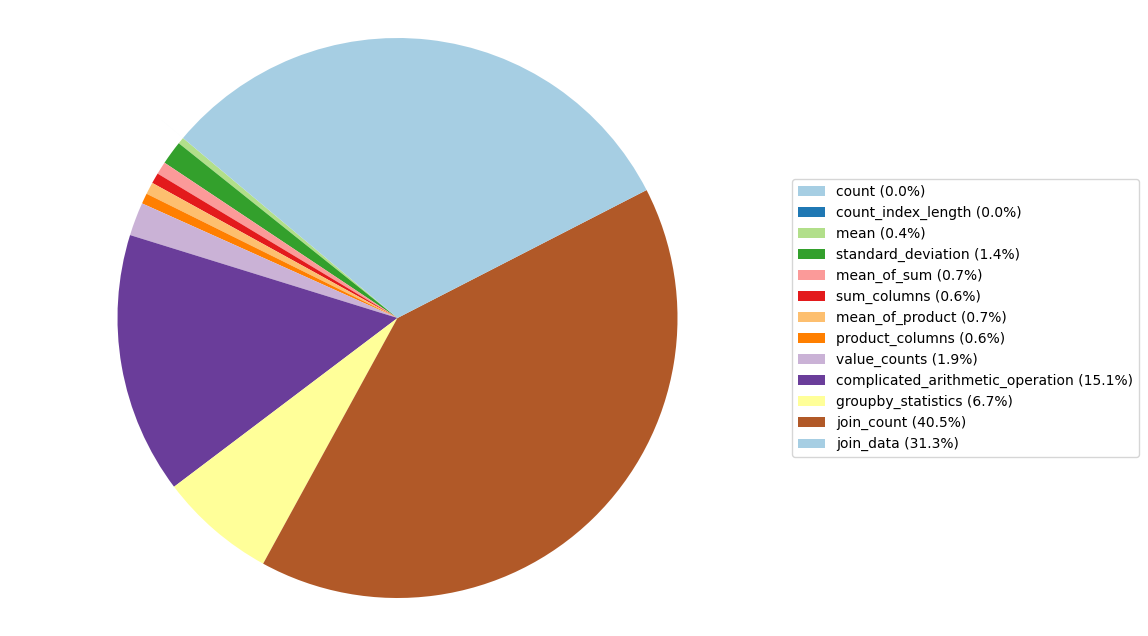

In [58]:
percentages = [f"{(d / sum(results_joblib_cache['duration']) * 100):.1f}%" for d in results_joblib_cache['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_joblib_cache['task'], percentages)]
colors = ['green' if task == 'read file' else color for task, color in zip(results_joblib_cache['task'], plt.cm.Paired.colors)]
explode = [0.1 if i == 0 else 0 for i in range(len(results_joblib_cache['duration']))]
plt.figure(figsize=(10, 8))
plt.pie(results_joblib_cache['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)
plt.axis('equal')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Análise das Operações

- As operações de junção e as aritméticas complexas são as que mais consomem tempo.
- A operação join_data apresentou uma redução no tempo em relação às operações padrão e de filtragem.
- A operação join_count teve um aumento no tempo em relação às operações padrão, mas diminuiu em comparação às operações de filtragem.
- A operação complicated_arithmetic_operation diminuiu o tempo em relação às operações padrão, mas aumentou em relação às de filtragem.
- As operações de contagem, como count e count_index_length, consomem muito pouco tempo.


# Gráfico de Linha em Dados persistidos

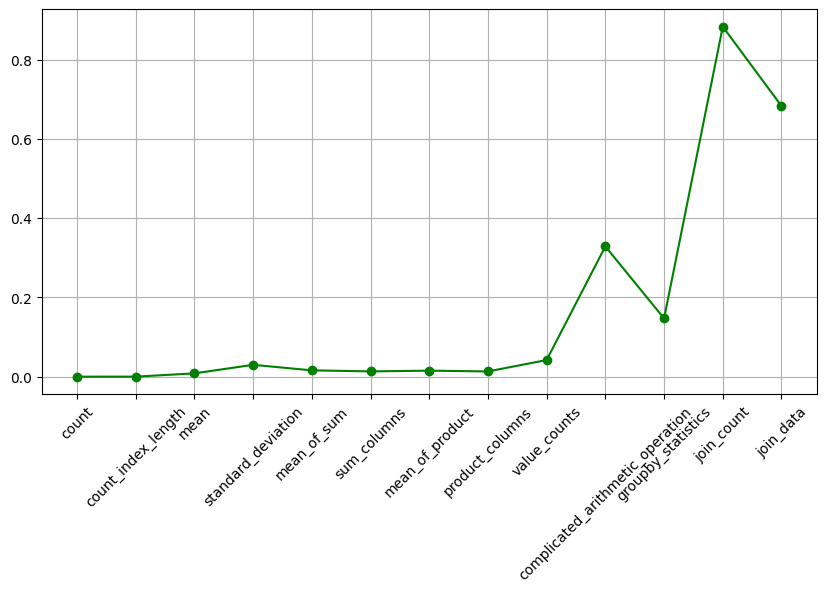

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(results_joblib_cache['task'], results_joblib_cache['duration'], marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Conclusões para Dados Persistidos

- As operações que mais consomem tempo são as junções e as operações aritméticas complexas, indicando que são as principais áreas para otimização.
- Operações simples como contagem, média e soma de colunas são muito rápidas e não precisam de otimização imediata.
- Esses padrões são similares aos observados nas operações padrão e de filtragem, porém com tempos de execução ainda menores.


# Repetição para 2 e 3 files

# Dask + Modin

In [60]:
parquet_files2 = ['Ficheiros/taxi_csv/yellow_tripdata_2009-11.parquet', 
                 'Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet']

parquet_files3 = [
    'Ficheiros/taxi_csv/yellow_tripdata_2009-10.parquet', 
    'Ficheiros/taxi_csv/yellow_tripdata_2009-11.parquet',
    'Ficheiros/taxi_csv/yellow_tripdata_2009-12.parquet'
]

modin_data2 = pd.read_parquet(parquet_files2)
modin_data3 = pd.read_parquet(parquet_files3)

In [61]:
modin_data2 = modin_data2.rename(columns=str.lower)
modin_data3 = modin_data3.rename(columns=str.lower)
print(modin_data2.columns)
print(modin_data3.columns)

Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')
Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')


In [62]:
def get_results(benchmarks):
    return pd.DataFrame.from_dict(benchmarks)

def read_file_parquet(df=None):
    return pd.read_parquet(parquet_file)

def count(df):
    return len(df)

def count_index_length(df):
    return len(df.index)

def mean(df):
    return df['fare_amt'].mean()

def standard_deviation(df):
    return df['fare_amt'].std()

def mean_of_sum(df):
    return (df['fare_amt'] + df['tip_amt']).mean()

def sum_columns(df):
    return (df['fare_amt'] + df['tip_amt']).sum()

def mean_of_product(df):
    return (df['fare_amt'] * df['tip_amt']).mean()

def product_columns(df):
    return (df['fare_amt'] * df['tip_amt']).sum()

def value_counts(df):
    return df['fare_amt'].value_counts()

def complicated_arithmetic_operation(df):
    theta_1 = df['start_lon']
    phi_1 = df['start_lat']
    theta_2 = df['end_lon']
    phi_2 = df['end_lat']
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180)
           * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1 - temp))
    return ret.mean()

def groupby_statistics(df):
    return df.groupby(by='passenger_count').agg({
        'fare_amt': ['mean', 'std'], 
        'tip_amt': ['mean', 'std']
    })

def join_count(df, other):
    return len(df.merge(other, left_index=True, right_index=True))

def join_data(df, other):
    return df.merge(other, left_index=True, right_index=True)

In [63]:
def benchmark(f, df, benchmarks, name, **kwargs):
    start_time = time.time()
    ret = f(df, **kwargs)
    benchmarks['duration'].append(time.time() - start_time)
    benchmarks['task'].append(name)
    print(f"{name} took: {benchmarks['duration'][-1]} seconds")
    return benchmarks['duration'][-1]

In [64]:
dfs = [modin_data2,modin_data3]

# Operações em dados completos

In [65]:
modin_benchmarks2 = {'duration': [], 'task': []}
modin_benchmarks3 = {'duration': [], 'task': []}

In [66]:
for i, df in enumerate(dfs):
    benchmark(count, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache count')
    benchmark(count_index_length, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache count index length')
    benchmark(mean, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache mean')
    benchmark(standard_deviation, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache standard deviation')
    benchmark(mean_of_sum, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache mean of columns addition')
    benchmark(sum_columns, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache addition of columns')
    benchmark(mean_of_product, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache mean of columns multiplication')
    benchmark(product_columns, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache multiplication of columns')
    benchmark(complicated_arithmetic_operation, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache complex arithmetic ops')
    benchmark(value_counts, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache value counts')
    benchmark(groupby_statistics, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache groupby statistics')

cache count took: 1.4781951904296875e-05 seconds
cache count index length took: 3.5762786865234375e-06 seconds
cache mean took: 0.060227155685424805 seconds
cache standard deviation took: 0.33305859565734863 seconds
cache mean of columns addition took: 0.165116548538208 seconds
cache addition of columns took: 0.1496870517730713 seconds
cache mean of columns multiplication took: 0.16605210304260254 seconds
cache multiplication of columns took: 0.14805078506469727 seconds
cache complex arithmetic ops took: 3.775177001953125 seconds
cache value counts took: 0.3208920955657959 seconds
cache groupby statistics took: 1.2108187675476074 seconds
cache count took: 8.821487426757812e-06 seconds
cache count index length took: 1.6689300537109375e-06 seconds
cache mean took: 0.09119009971618652 seconds
cache standard deviation took: 0.5131795406341553 seconds
cache mean of columns addition took: 0.2574341297149658 seconds
cache addition of columns took: 0.23130464553833008 seconds
cache mean of col

In [67]:
modin_res_temp2 = get_results(modin_benchmarks2).drop_duplicates(subset='task').set_index('task')
modin_res_temp3 = get_results(modin_benchmarks3).drop_duplicates(subset='task').set_index('task')
print(modin_res_temp2)
print(modin_res_temp3)
filename2 = 'Resultados/modin_standard2'
filename3 = 'Resultados/modin_standard3'
modin_res_temp2.to_parquet(filename2)
modin_res_temp3.to_parquet(filename3)
print(f'Guardado em {filename2}.')
print(f'Guardado em {filename3}.')

                                      duration
task                                          
cache count                           0.000015
cache count index length              0.000004
cache mean                            0.060227
cache standard deviation              0.333059
cache mean of columns addition        0.165117
cache addition of columns             0.149687
cache mean of columns multiplication  0.166052
cache multiplication of columns       0.148051
cache complex arithmetic ops          3.775177
cache value counts                    0.320892
cache groupby statistics              1.210819
                                      duration
task                                          
cache count                           0.000009
cache count index length              0.000002
cache mean                            0.091190
cache standard deviation              0.513180
cache mean of columns addition        0.257434
cache addition of columns             0.231305
cache mean of

# cProfile para amostras de 2 e 3 ficheiros

In [68]:
import cProfile
import matplotlib.pyplot as plt
from io import StringIO
import pstats

In [69]:
def benchmark_with_cprofile(f, df, benchmarks, name, **kwargs):
    pr = cProfile.Profile()
    pr.enable()
    
    start_time = time.time()
    ret = f(df, **kwargs)
    benchmarks['duration'].append(time.time() - start_time)
    benchmarks['task'].append(name)
    print(f"{name} took: {benchmarks['duration'][-1]} seconds")
    
    pr.disable()
    pr.print_stats(sort='cumtime') 
    
    return benchmarks['duration'][-1]

In [70]:
modin_benchmarks2_cprofile = {'duration': [], 'task': []}
modin_benchmarks3_cprofile = {'duration': [], 'task': []}

In [71]:
modin_data = [modin_data2,modin_data3]

# Cprofile para modin_data2 (2 meses)

In [72]:
benchmark_with_cprofile(count, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache count')
benchmark_with_cprofile(count_index_length, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache count index length')
benchmark_with_cprofile(mean, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache mean')
benchmark_with_cprofile(standard_deviation, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache standard deviation')
benchmark_with_cprofile(mean_of_sum, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache mean of columns addition')
benchmark_with_cprofile(sum_columns, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache addition of columns')
benchmark_with_cprofile(mean_of_product, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache mean of columns multiplication')
benchmark_with_cprofile(product_columns, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache multiplication of columns')
benchmark_with_cprofile(complicated_arithmetic_operation, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache complex arithmetic ops')
benchmark_with_cprofile(value_counts, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache value counts')
benchmark_with_cprofile(groupby_statistics, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache groupby statistics')

cache count took: 1.7642974853515625e-05 seconds
         44 function calls (42 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 iostream.py:655(write)
        2    0.000    0.000    0.000    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.000    0.000 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 socket.py:623(send)
        1    0.000    0.000    0.000    0.000 631048046.py:7(count)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 frame.py:1643(__len__)
        1    0.000    0.000    0.000    0.000 threading.py:1169(is_alive)
        2    0.000    0.000    0.000    0.000 iostream.py:550(_is_master_process)
        2    0.000    0.000    0.000    0.000 

1.2314503192901611

In [73]:
results_modin2 = pd.DataFrame.from_dict(modin_benchmarks2_cprofile)

Cprofile para modin_data3 (3 meses)

In [74]:
benchmark_with_cprofile(count, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache count')
benchmark_with_cprofile(count_index_length, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache count index length')
benchmark_with_cprofile(mean, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache mean')
benchmark_with_cprofile(standard_deviation, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache standard deviation')
benchmark_with_cprofile(mean_of_sum, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache mean of columns addition')
benchmark_with_cprofile(sum_columns, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache addition of columns')
benchmark_with_cprofile(mean_of_product, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache mean of columns multiplication')
benchmark_with_cprofile(product_columns, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache multiplication of columns')
benchmark_with_cprofile(complicated_arithmetic_operation, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache complex arithmetic ops')
benchmark_with_cprofile(value_counts, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache value counts')
benchmark_with_cprofile(groupby_statistics, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache groupby statistics')

cache count took: 1.7404556274414062e-05 seconds
         44 function calls (42 primitive calls) in 0.001 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.001    0.001 {built-in method builtins.print}
        2    0.000    0.000    0.001    0.000 iostream.py:655(write)
        2    0.000    0.000    0.001    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.001    0.001 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 socket.py:623(send)
        1    0.000    0.000    0.000    0.000 631048046.py:7(count)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 frame.py:1643(__len__)
        1    0.000    0.000    0.000    0.000 threading.py:1169(is_alive)
        2    0.000    0.000    0.000    0.000 iostream.py:550(_is_master_process)
        2    0.000    0.000    0.000    0.000 

1.8635671138763428

In [75]:
results_modin3 = pd.DataFrame.from_dict(modin_benchmarks3_cprofile)

# Gráfico de Barras Horizontais: Data de 2 meses

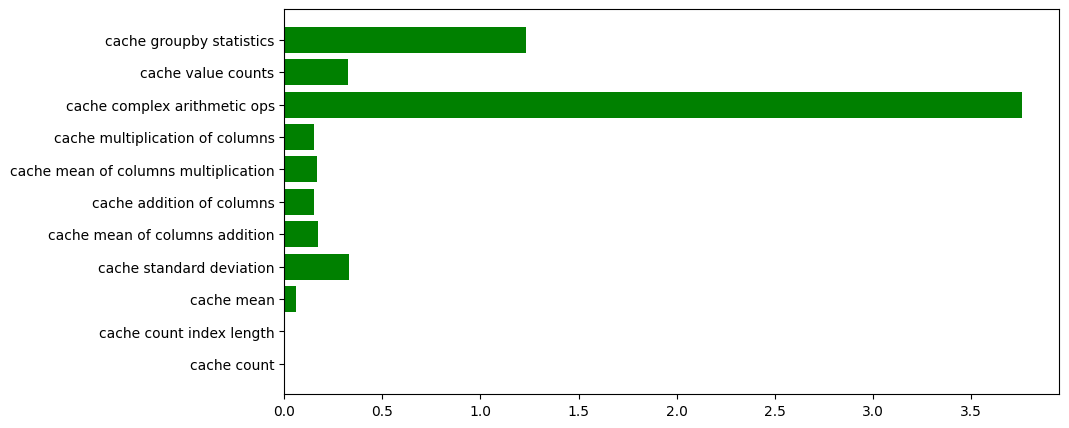

In [76]:
plt.figure(figsize=(10, 5))
plt.barh(results_modin2['task'], results_modin2['duration'], color='green')
plt.show()

# Gráfico de Barras Horizontais: Data de 3 meses

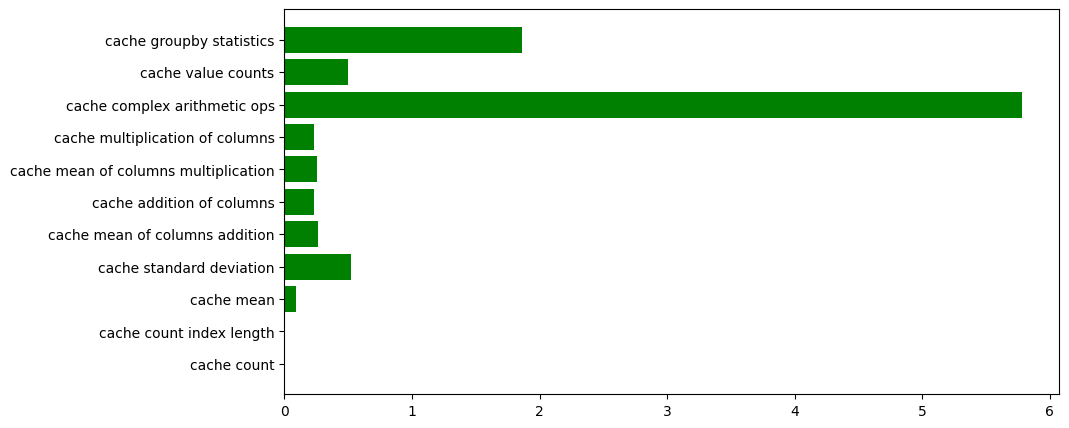

In [77]:
plt.figure(figsize=(10, 5))
plt.barh(results_modin3['task'], results_modin3['duration'], color='green')
plt.show()

# Gráfico Pizza: Data de 2 meses

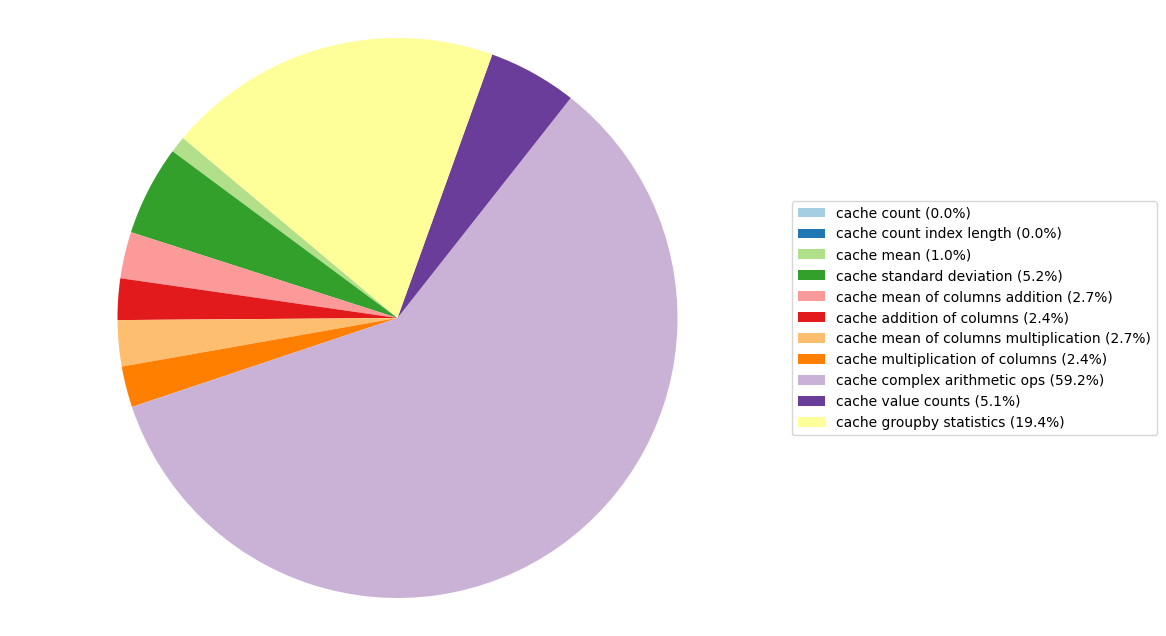

In [78]:
percentages = [f"{(d / sum(results_modin2['duration']) * 100):.1f}%" for d in results_modin2['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin2['task'], percentages)]
colors = ['green' if task == 'read file' else color for task, color in zip(results_modin2['task'], plt.cm.Paired.colors)]
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin2['duration']))]
plt.figure(figsize=(10, 8))
plt.pie(results_modin2['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

plt.axis('equal')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Gráfico Pizza: Data de 3 meses

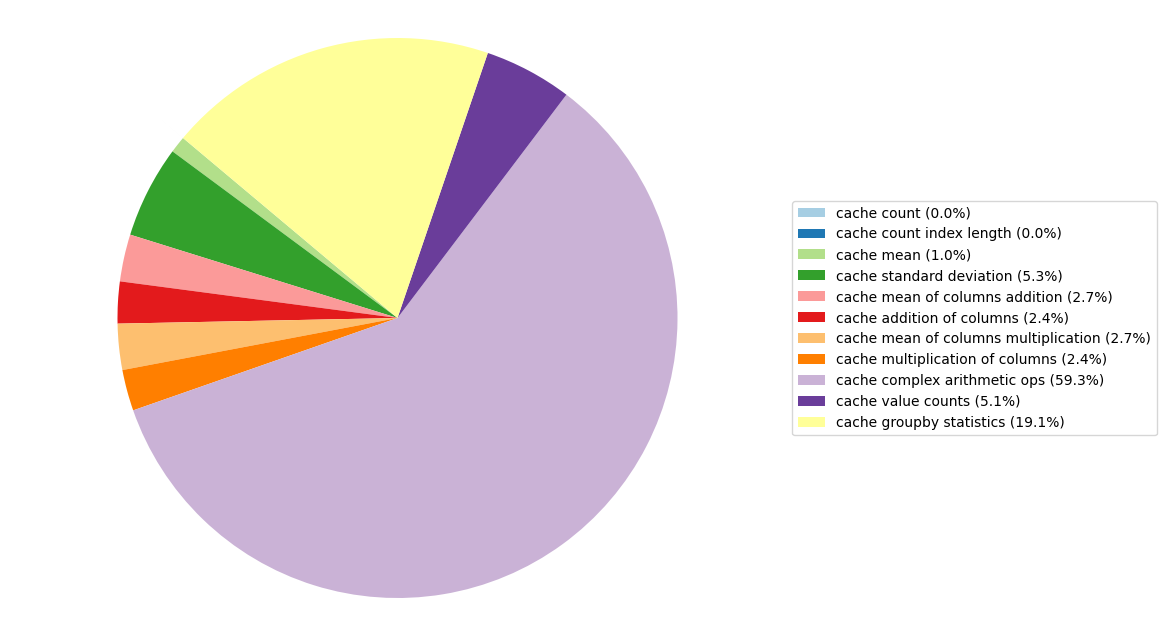

In [79]:
percentages = [f"{(d / sum(results_modin3['duration']) * 100):.1f}%" for d in results_modin3['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin3['task'], percentages)]
colors = ['green' if task == 'read file' else color for task, color in zip(results_modin3['task'], plt.cm.Paired.colors)]
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin3['duration']))]
plt.figure(figsize=(10, 8))
plt.pie(results_modin3['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)
plt.axis('equal')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Análise das Operações em Cache

- As operações de aritmética complexa e estatísticas de agrupamento são as que consomem mais tempo.
- Ambas mantêm uma participação consistente no tempo total para as diferentes amostras analisadas.


# Gráfico de linhas: Data de 2 meses

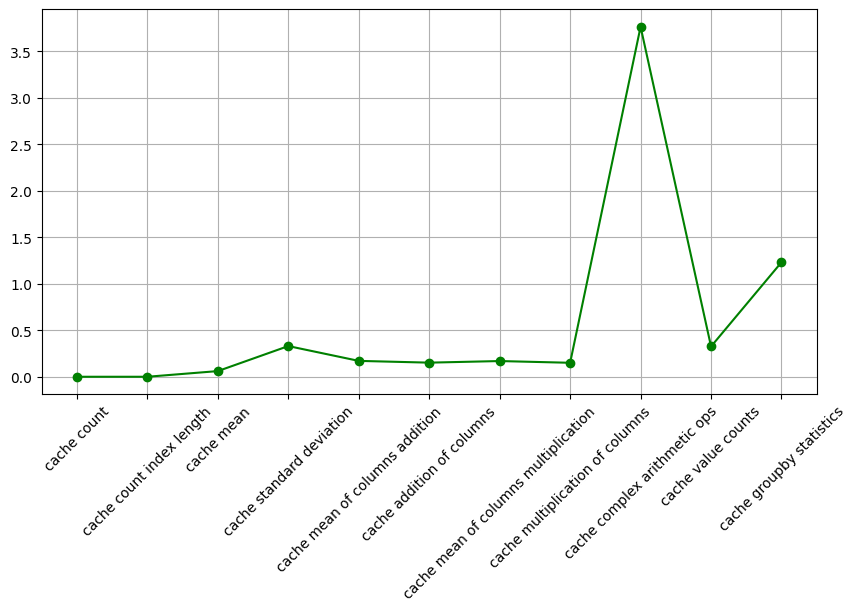

In [80]:
plt.figure(figsize=(10, 5))
plt.plot(results_modin2['task'], results_modin2['duration'], marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Gráfico de linhas: Data de 3 meses

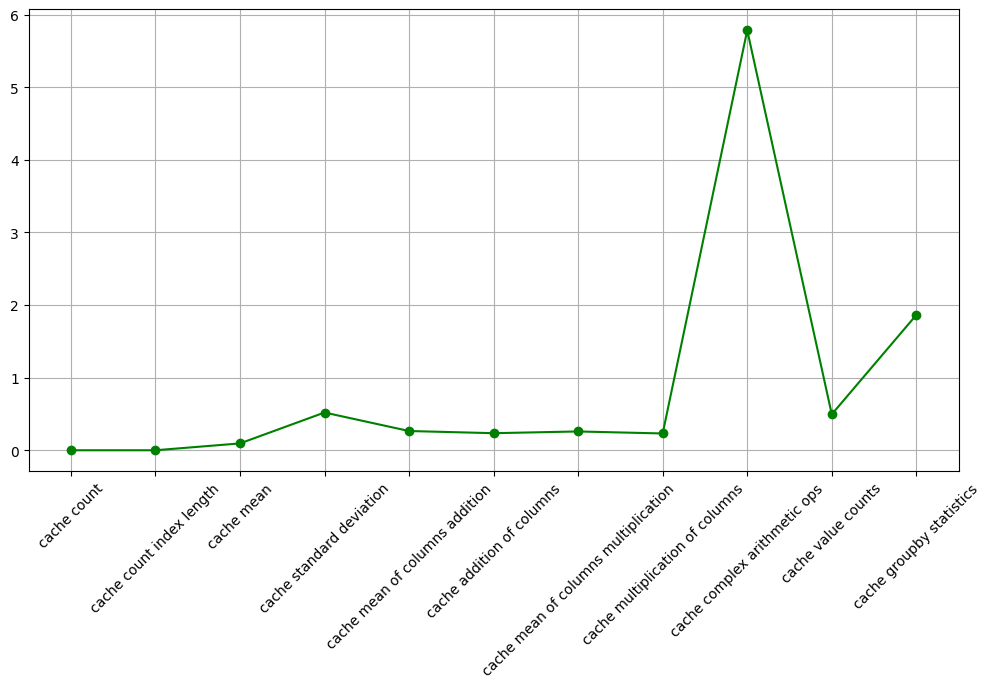

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(results_modin3['task'], results_modin3['duration'], marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Conclusões para Dados Completos

- As operações de aritmética complexa em cache e estatísticas de agrupamento em cache consomem a maior parte do tempo.
- Essas áreas devem ser priorizadas para otimização do desempenho.


# Operações com dados filtrados

In [82]:
expr_filter2 = 'tip_amt >= 1 and tip_amt <= 5'
modin_filtered2 = modin_data2.query(expr_filter2)
if not isinstance(modin_filtered2, pd.DataFrame):
    modin_filtered2 = pd.DataFrame(modin_filtered2)
modin_benchmarks_filtered2 = {'duration': [], 'task': []}

In [83]:
expr_filter3 = 'tip_amt >= 1 and tip_amt <= 5'
modin_filtered3 = modin_data3.query(expr_filter3)
if not isinstance(modin_filtered3, pd.DataFrame):
    modin_filtered3 = pd.DataFrame(modin_filtered3)
modin_benchmarks_filtered3 = {'duration': [], 'task': []}

In [84]:
modin_filtered = [modin_filtered2,modin_filtered3]

In [85]:
for i, df in enumerate(modin_filtered):
    benchmark(count, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache count')
    benchmark(count_index_length, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache count index length')
    benchmark(mean, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache mean')
    benchmark(standard_deviation, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache standard deviation')
    benchmark(mean_of_sum, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache mean of columns addition')
    benchmark(sum_columns, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache addition of columns')
    benchmark(mean_of_product, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache mean of columns multiplication')
    benchmark(product_columns, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache multiplication of columns')
    benchmark(complicated_arithmetic_operation, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache complex arithmetic ops')
    benchmark(value_counts, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache value counts')
    benchmark(groupby_statistics, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache groupby statistics')

cache count took: 1.239776611328125e-05 seconds
cache count index length took: 5.245208740234375e-06 seconds
cache mean took: 0.015623092651367188 seconds
cache standard deviation took: 0.07043099403381348 seconds
cache mean of columns addition took: 0.031339406967163086 seconds
cache addition of columns took: 0.026841163635253906 seconds
cache mean of columns multiplication took: 0.031000137329101562 seconds
cache multiplication of columns took: 0.02679133415222168 seconds
cache complex arithmetic ops took: 0.8096358776092529 seconds
cache value counts took: 0.08183097839355469 seconds
cache groupby statistics took: 0.3013148307800293 seconds
cache count took: 5.4836273193359375e-06 seconds
cache count index length took: 1.430511474609375e-06 seconds
cache mean took: 0.022948503494262695 seconds
cache standard deviation took: 0.1278059482574463 seconds
cache mean of columns addition took: 0.06353020668029785 seconds
cache addition of columns took: 0.05797410011291504 seconds
cache mea

In [86]:
modin_res_filter2 = get_results(modin_benchmarks_filtered2).drop_duplicates(subset='task').set_index('task')
modin_res_filter3 = get_results(modin_benchmarks_filtered3).drop_duplicates(subset='task').set_index('task')
print(modin_res_filter2)
print(modin_res_filter3)
filename_filter2 = 'Resultados/modin_filtered2'
filename_filter3 = 'Resultados/modin_filtered3'
modin_res_filter2.to_parquet(filename_filter2)
modin_res_filter3.to_parquet(filename_filter3)
print(f'Guardado em {filename_filter2}.')
print(f'Guardado em {filename_filter3}.')

                                      duration
task                                          
cache count                           0.000012
cache count index length              0.000005
cache mean                            0.015623
cache standard deviation              0.070431
cache mean of columns addition        0.031339
cache addition of columns             0.026841
cache mean of columns multiplication  0.031000
cache multiplication of columns       0.026791
cache complex arithmetic ops          0.809636
cache value counts                    0.081831
cache groupby statistics              0.301315
                                      duration
task                                          
cache count                           0.000005
cache count index length              0.000001
cache mean                            0.022949
cache standard deviation              0.127806
cache mean of columns addition        0.063530
cache addition of columns             0.057974
cache mean of

In [87]:
modin_benchmarks2_filtered_cprofile = {'duration': [], 'task': []}
modin_benchmarks3_filtered_cprofile = {'duration': [], 'task': []}

In [88]:
benchmark_with_cprofile(count, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache count')
benchmark_with_cprofile(count_index_length, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache count index length')
benchmark_with_cprofile(mean, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache mean')
benchmark_with_cprofile(standard_deviation, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache standard deviation')
benchmark_with_cprofile(mean_of_sum, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache mean of columns addition')
benchmark_with_cprofile(sum_columns, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache addition of columns')
benchmark_with_cprofile(mean_of_product, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache mean of columns multiplication')
benchmark_with_cprofile(product_columns, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache multiplication of columns')
benchmark_with_cprofile(complicated_arithmetic_operation, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache complex arithmetic ops')
benchmark_with_cprofile(value_counts, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache value counts')
benchmark_with_cprofile(groupby_statistics, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache groupby statistics')

cache count took: 1.9311904907226562e-05 seconds
         44 function calls (42 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 iostream.py:655(write)
        2    0.000    0.000    0.000    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.000    0.000 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 socket.py:623(send)
        1    0.000    0.000    0.000    0.000 631048046.py:7(count)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 frame.py:1643(__len__)
        2    0.000    0.000    0.000    0.000 {built-in method time.time}
        1    0.000    0.000    0.000    0.000 threading.py:1169(is_alive)
        2    0.000    0.000    0.000    0.000 iostream

0.3052945137023926

In [89]:
results_modin_filtered2 = pd.DataFrame.from_dict(modin_benchmarks2_filtered_cprofile)

In [90]:
benchmark_with_cprofile(count, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache count')
benchmark_with_cprofile(count_index_length, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache count index length')
benchmark_with_cprofile(mean, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache mean')
benchmark_with_cprofile(standard_deviation, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache standard deviation')
benchmark_with_cprofile(mean_of_sum, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache mean of columns addition')
benchmark_with_cprofile(sum_columns, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache addition of columns')
benchmark_with_cprofile(mean_of_product, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache mean of columns multiplication')
benchmark_with_cprofile(product_columns, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache multiplication of columns')
benchmark_with_cprofile(complicated_arithmetic_operation, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache complex arithmetic ops')
benchmark_with_cprofile(value_counts, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache value counts')
benchmark_with_cprofile(groupby_statistics, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache groupby statistics')

cache count took: 1.8596649169921875e-05 seconds
         44 function calls (42 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 iostream.py:655(write)
        2    0.000    0.000    0.000    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.000    0.000 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 socket.py:623(send)
        1    0.000    0.000    0.000    0.000 631048046.py:7(count)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 frame.py:1643(__len__)
        1    0.000    0.000    0.000    0.000 threading.py:1169(is_alive)
        2    0.000    0.000    0.000    0.000 iostream.py:550(_is_master_process)
        2    0.000    0.000    0.000    0.000 

0.4796719551086426

In [91]:
results_modin_filtered3 = pd.DataFrame.from_dict(modin_benchmarks3_filtered_cprofile)

# Gráfico de Barras Horizontais em dados filtrados com cProfile: Amostra de 2 ficheiros

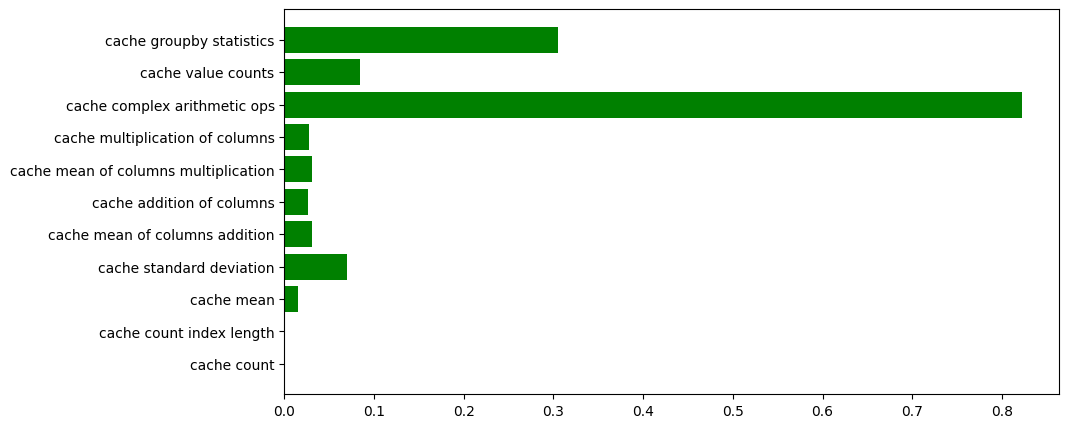

In [92]:
plt.figure(figsize=(10, 5))
plt.barh(results_modin_filtered2['task'], results_modin_filtered2['duration'], color='green')
plt.show()

# Gráfico de Barras Horizontais em dados filtrados com cProfile: Amostra de 3 ficheiros


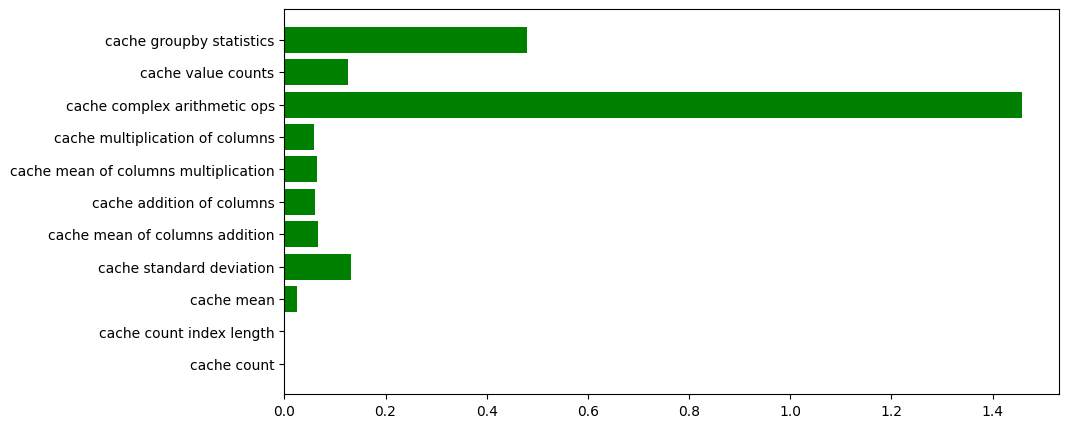

In [93]:
plt.figure(figsize=(10, 5))
plt.barh(results_modin_filtered3['task'], results_modin_filtered3['duration'], color='green')
plt.show()

### Análise de Desempenho por Amostras

- As tarefas que mais consomem tempo são operações de aritmética complexa em cache e estatísticas de agrupamento em cache.
- Conforme esperado, a amostra com três arquivos leva mais tempo para ser processada.
- Ambas as amostras apresentam tempos menores em dados filtrados comparados às operações padrão.


# Gráfico Pizza em dados filtrados com cProfile: Amostra de 2 ficheiros


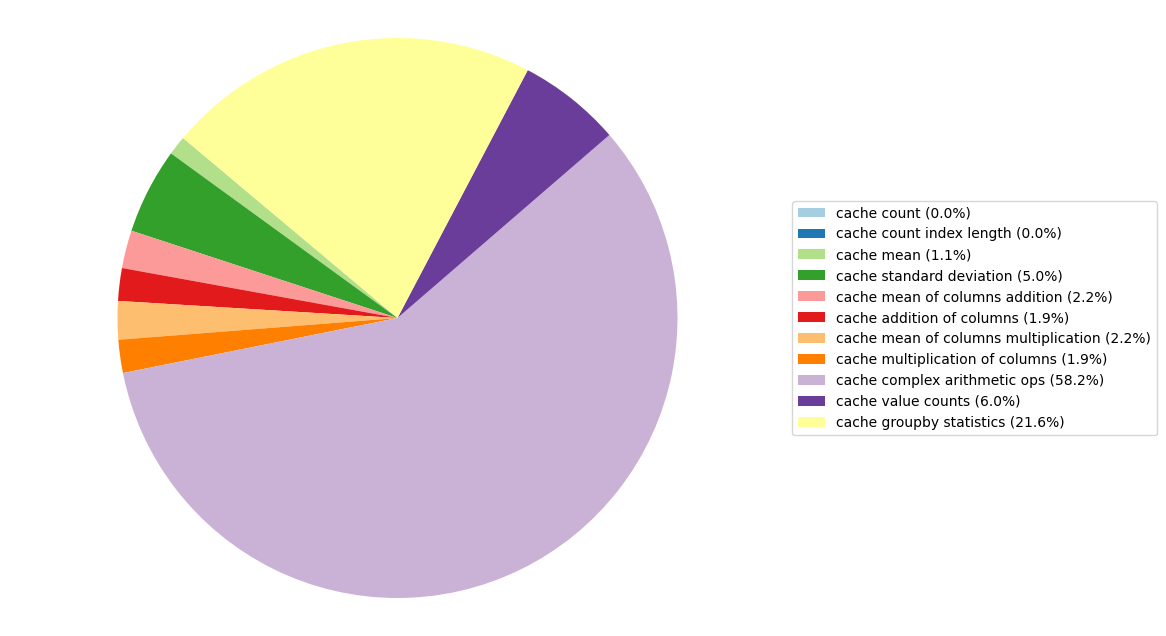

In [94]:
percentages = [f"{(d / sum(results_modin_filtered2['duration']) * 100):.1f}%" for d in results_modin_filtered2['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin_filtered2['task'], percentages)]
colors = ['green' if task == 'read file' else color for task, color in zip(results_modin_filtered2['task'], plt.cm.Paired.colors)]
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin_filtered2['duration']))]
plt.figure(figsize=(10, 8))
plt.pie(results_modin_filtered2['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)
plt.axis('equal')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Gráfico Pizza em dados filtrados com cProfile: Amostra de 3 ficheiros

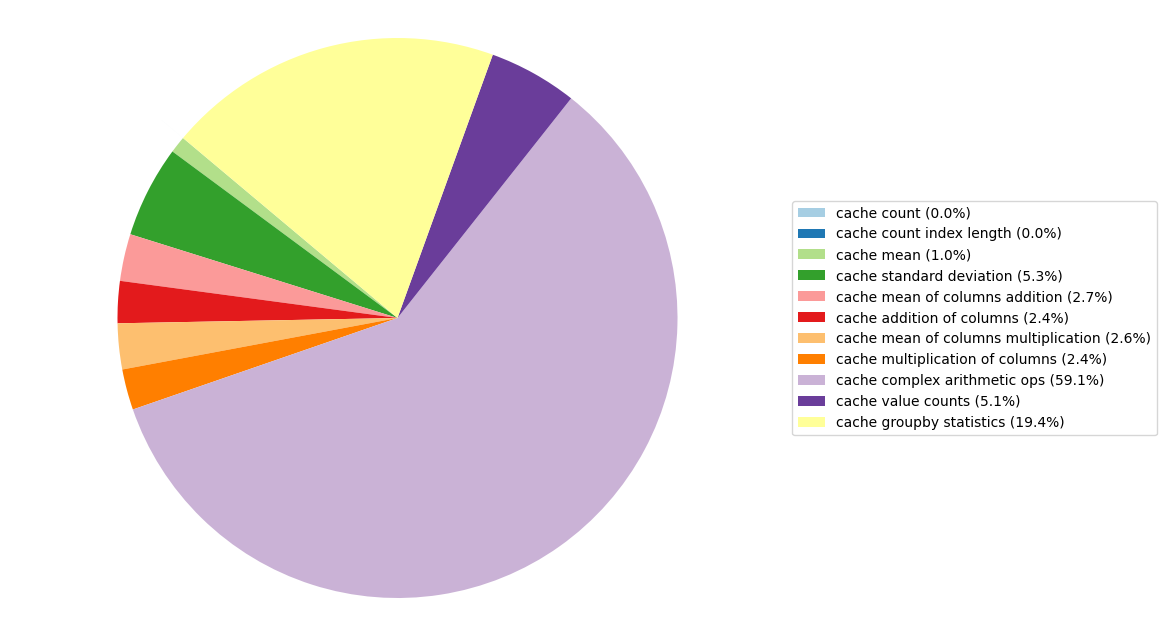

In [95]:
percentages = [f"{(d / sum(results_modin_filtered3['duration']) * 100):.1f}%" for d in results_modin_filtered3['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin_filtered3['task'], percentages)]
colors = ['green' if task == 'read file' else color for task, color in zip(results_modin_filtered3['task'], plt.cm.Paired.colors)]
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin_filtered3['duration']))]
plt.figure(figsize=(10, 8))
plt.pie(results_modin_filtered3['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)
plt.axis('equal')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Análise de Desempenho das Operações em Cache

- As operações de aritmética complexa em cache e as estatísticas de agrupamento em cache são as que consomem mais tempo.
- Ambas as amostras apresentam percentuais similares de tempo gasto nessas operações.


# Gráfico de linha em dados filtrados com cProfile: Amostra de 2 ficheiros


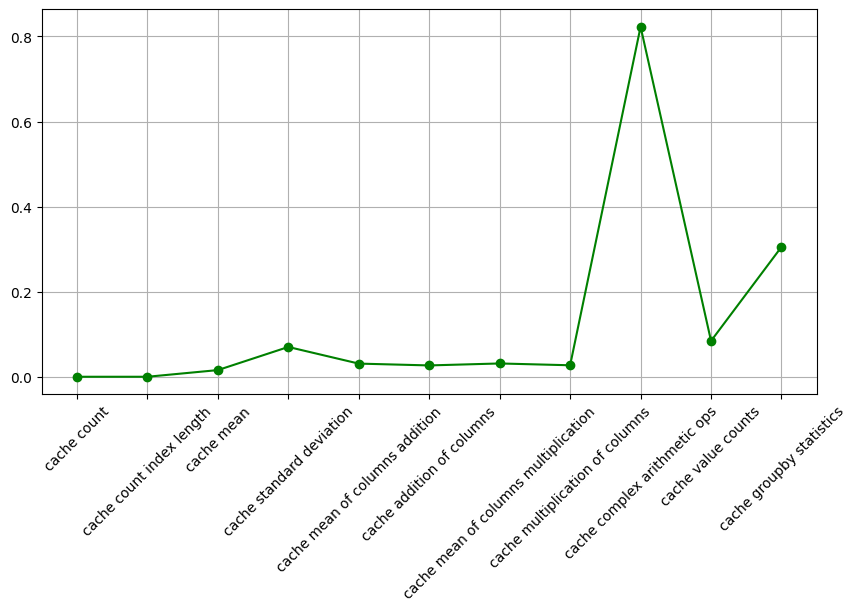

In [96]:
plt.figure(figsize=(10, 5))
plt.plot(results_modin_filtered2['task'], results_modin_filtered2['duration'], marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Gráfico de linha em dados filtrados com cProfile: Amostra de 3 ficheiros

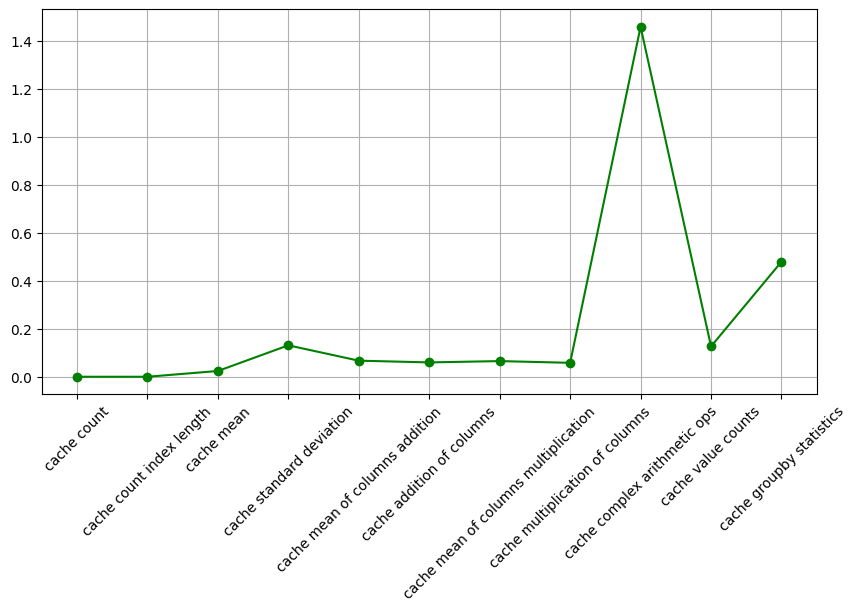

In [97]:
plt.figure(figsize=(10, 5))
plt.plot(results_modin_filtered3['task'], results_modin_filtered3['duration'], marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Conclusões em Dados Filtrados

- As operações de aritmética complexa em cache e estatísticas de agrupamento em cache são as que mais consomem tempo.
- Essas áreas devem ser priorizadas para otimização.


# Operações em dados filtrados com cache

In [98]:
if isinstance(modin_filtered[0], pd.DataFrame):
    print(modin_filtered[0].head())
    dask_df = modin_filtered[0]
else:
    raise TypeError("Error")
dask_df = dd.from_pandas(dask_df, npartitions=10)
dask_df = client.persist(dask_df)
modin_cache2 = dask_df
modin_benchmarks_cache2 = {'duration': [], 'task': []}

   vendor_name trip_pickup_datetime trip_dropoff_datetime  passenger_count  \
5          VTS  2009-11-17 09:25:00   2009-11-17 09:32:00                2   
7          VTS  2009-11-01 15:15:00   2009-11-01 15:28:00                1   
10         VTS  2009-11-17 09:47:00   2009-11-17 09:58:00                1   
23         VTS  2009-11-17 21:22:00   2009-11-17 21:28:00                1   
24         VTS  2009-11-17 18:40:00   2009-11-17 18:59:00                5   

    trip_distance  start_lon  start_lat  rate_code  store_and_forward  \
5            1.53 -73.985087  40.741617        NaN                NaN   
7            2.63 -73.987970  40.769763        NaN                NaN   
10           2.05 -74.005080  40.723133        NaN                NaN   
23           1.59 -73.989603  40.772788        NaN                NaN   
24           2.70 -73.969435  40.748600        NaN                NaN   

      end_lon    end_lat payment_type  fare_amt  surcharge  mta_tax  tip_amt  \
5  -73.97274

This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.


In [99]:
if isinstance(modin_filtered[1], pd.DataFrame):
    print(modin_filtered[1].head())
    dask_df = modin_filtered[1]
else:
    raise TypeError("Error")
dask_df = dd.from_pandas(dask_df, npartitions=10)
dask_df = client.persist(dask_df)
modin_cache3 = dask_df
modin_benchmarks_cache3 = {'duration': [], 'task': []}

   vendor_name trip_pickup_datetime trip_dropoff_datetime  passenger_count  \
5          VTS  2009-10-26 08:27:00   2009-10-26 08:34:00                1   
9          VTS  2009-10-27 17:26:00   2009-10-27 17:48:00                1   
10         VTS  2009-10-26 10:25:00   2009-10-26 10:29:00                5   
14         VTS  2009-10-26 07:20:00   2009-10-26 07:28:00                2   
19         VTS  2009-10-26 10:12:00   2009-10-26 10:17:00                1   

    trip_distance  start_lon  start_lat  rate_code  store_and_forward  \
5            0.73 -73.997095  40.722483        NaN                NaN   
9            4.82 -74.011060  40.701725        NaN                NaN   
10           0.75 -73.972490  40.752168        NaN                NaN   
14           1.21 -73.990392  40.756352        NaN                NaN   
19           0.90 -73.985927  40.740690        NaN                NaN   

      end_lon    end_lat payment_type  fare_amt  surcharge  mta_tax  tip_amt  \
5  -73.98734

This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.


In [100]:
modin_cache = [modin_cache2,modin_cache3]

In [101]:
for i, df in enumerate(modin_cache):
    benchmark(count, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache count')
    benchmark(count_index_length, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache count index length')
    benchmark(mean, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache mean')
    benchmark(standard_deviation, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache standard deviation')
    benchmark(mean_of_sum, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache mean of columns addition')
    benchmark(sum_columns, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache addition of columns')
    benchmark(mean_of_product, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache mean of columns multiplication')
    benchmark(product_columns, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache multiplication of columns')
    benchmark(complicated_arithmetic_operation, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache complex arithmetic ops')
    benchmark(value_counts, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache value counts')
    benchmark(groupby_statistics, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache groupby statistics')

cache count took: 29.612004041671753 seconds
cache count index length took: 0.06578326225280762 seconds
cache mean took: 0.0010769367218017578 seconds
cache standard deviation took: 0.004884243011474609 seconds
cache mean of columns addition took: 0.0017740726470947266 seconds
cache addition of columns took: 0.0019512176513671875 seconds
cache mean of columns multiplication took: 0.0015647411346435547 seconds
cache multiplication of columns took: 0.0018260478973388672 seconds
cache complex arithmetic ops took: 0.03648233413696289 seconds
cache value counts took: 0.0007550716400146484 seconds
cache groupby statistics took: 0.02109980583190918 seconds
cache count took: 0.07151198387145996 seconds
cache count index length took: 0.07242679595947266 seconds
cache mean took: 0.001201629638671875 seconds
cache standard deviation took: 0.00463414192199707 seconds
cache mean of columns addition took: 0.0020477771759033203 seconds
cache addition of columns took: 0.00235748291015625 seconds
cache

In [102]:
modin_res_cache2 = get_results(modin_benchmarks_cache2).drop_duplicates(subset='task').set_index('task')
modin_res_cache3 = get_results(modin_benchmarks_cache3).drop_duplicates(subset='task').set_index('task')
print(modin_res_cache2)
print(modin_res_cache3)
filename_cache2 = 'Resultados/modin_cache2'
filename_cache3 = 'Resultados/modin_cache3'
modin_res_cache2.to_parquet(filename_cache2)
modin_res_cache3.to_parquet(filename_cache3)

print(f'Guardado em {filename_cache2}.')
print(f'Guardado em {filename_cache3}.')

                                       duration
task                                           
cache count                           29.612004
cache count index length               0.065783
cache mean                             0.001077
cache standard deviation               0.004884
cache mean of columns addition         0.001774
cache addition of columns              0.001951
cache mean of columns multiplication   0.001565
cache multiplication of columns        0.001826
cache complex arithmetic ops           0.036482
cache value counts                     0.000755
cache groupby statistics               0.021100
                                      duration
task                                          
cache count                           0.071512
cache count index length              0.072427
cache mean                            0.001202
cache standard deviation              0.004634
cache mean of columns addition        0.002048
cache addition of columns             0.002357


# CProfile em dados filtrados com cache para amostra de 2 ficheiros


In [103]:
modin_benchmarks2_cache_cprofile = {'duration': [], 'task': []}
modin_benchmarks3_cache_cprofile = {'duration': [], 'task': []}

In [104]:
benchmark_with_cprofile(count, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache count')
benchmark_with_cprofile(count_index_length, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache count index length')
benchmark_with_cprofile(mean, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache mean')
benchmark_with_cprofile(standard_deviation, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache standard deviation')
benchmark_with_cprofile(mean_of_sum, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache mean of columns addition')
benchmark_with_cprofile(sum_columns, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache addition of columns')
benchmark_with_cprofile(mean_of_product, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache mean of columns multiplication')
benchmark_with_cprofile(product_columns, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache multiplication of columns')
benchmark_with_cprofile(complicated_arithmetic_operation, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache complex arithmetic ops')
benchmark_with_cprofile(value_counts, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache value counts')
benchmark_with_cprofile(groupby_statistics, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache groupby statistics')

cache count took: 0.058814048767089844 seconds
         10547 function calls (9927 primitive calls) in 0.059 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.059    0.059 631048046.py:7(count)
    491/3    0.000    0.000    0.059    0.020 {built-in method builtins.len}
        1    0.000    0.000    0.059    0.059 _collection.py:390(__len__)
        1    0.000    0.000    0.048    0.048 base.py:349(compute)
        1    0.000    0.000    0.048    0.048 base.py:597(compute)
        1    0.000    0.000    0.045    0.045 client.py:3390(get)
        1    0.000    0.000    0.042    0.042 client.py:2493(gather)
        1    0.000    0.000    0.042    0.042 utils.py:364(sync)
        1    0.000    0.000    0.042    0.042 utils.py:393(sync)
        1    0.000    0.000    0.042    0.042 utils.py:436(wait)
        1    0.000    0.000    0.042    0.042 threading.py:589(wait)
        1    0.000    0.00

0.034924983978271484

In [105]:
results_modin_cache2 = pd.DataFrame.from_dict(modin_benchmarks2_cache_cprofile)

CProfile para data de 3 meses

In [106]:
benchmark_with_cprofile(count, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache count')
benchmark_with_cprofile(count_index_length, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache count index length')
benchmark_with_cprofile(mean, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache mean')
benchmark_with_cprofile(standard_deviation, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache standard deviation')
benchmark_with_cprofile(mean_of_sum, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache mean of columns addition')
benchmark_with_cprofile(sum_columns, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache addition of columns')
benchmark_with_cprofile(mean_of_product, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache mean of columns multiplication')
benchmark_with_cprofile(product_columns, modin_cache[1], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache multiplication of columns')
benchmark_with_cprofile(complicated_arithmetic_operation, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache complex arithmetic ops')
benchmark_with_cprofile(value_counts, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache value counts')
benchmark_with_cprofile(groupby_statistics, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache groupby statistics')

cache count took: 0.06362771987915039 seconds
         10508 function calls (9888 primitive calls) in 0.065 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.064    0.064 631048046.py:7(count)
    491/3    0.000    0.000    0.064    0.021 {built-in method builtins.len}
        1    0.000    0.000    0.064    0.064 _collection.py:390(__len__)
        1    0.000    0.000    0.053    0.053 base.py:349(compute)
        1    0.000    0.000    0.053    0.053 base.py:597(compute)
        1    0.000    0.000    0.050    0.050 client.py:3390(get)
        1    0.000    0.000    0.050    0.050 client.py:2493(gather)
        1    0.000    0.000    0.050    0.050 utils.py:364(sync)
        1    0.000    0.000    0.049    0.049 utils.py:393(sync)
        1    0.000    0.000    0.049    0.049 utils.py:436(wait)
        1    0.000    0.000    0.049    0.049 threading.py:589(wait)
        1    0.000    0.000

0.03432917594909668

In [107]:
results_modin_cache3 = pd.DataFrame.from_dict(modin_benchmarks3_cache_cprofile)

# Gráfico de barras horizontais: Data de 2 meses

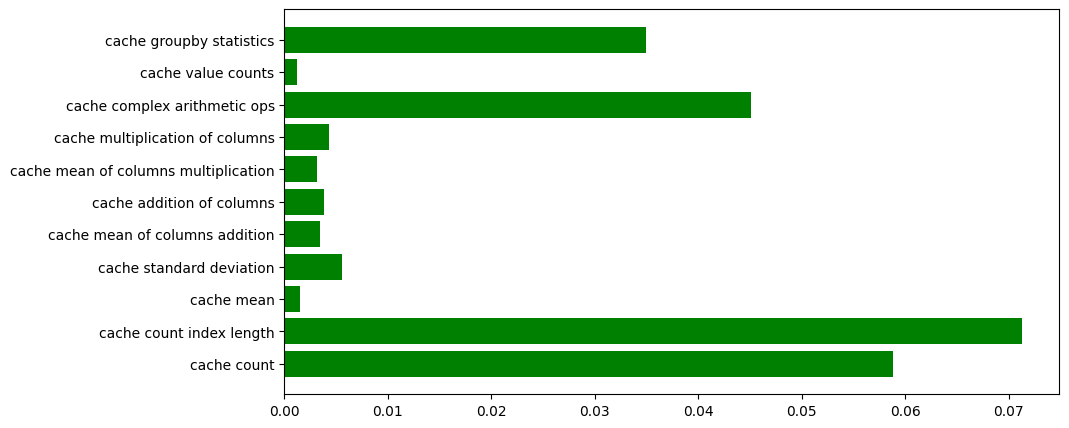

In [108]:
plt.figure(figsize=(10, 5))
plt.barh(results_modin_cache2['task'], results_modin_cache2['duration'], color='green')
plt.show()

# Gráfico de barras horizontais: Data de 3 meses

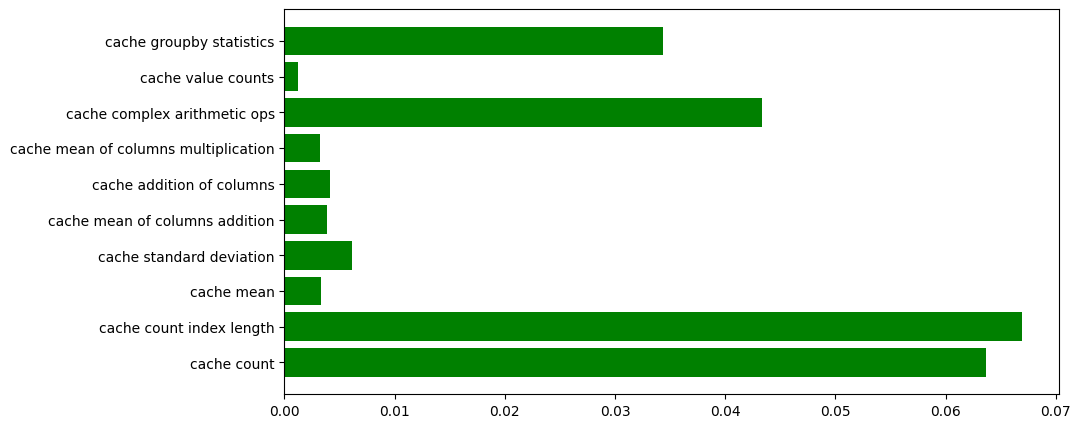

In [109]:
plt.figure(figsize=(10, 5))
plt.barh(results_modin_cache3['task'], results_modin_cache3['duration'], color='green')
plt.show()

# Gráfico Pizza: Data de 2 meses

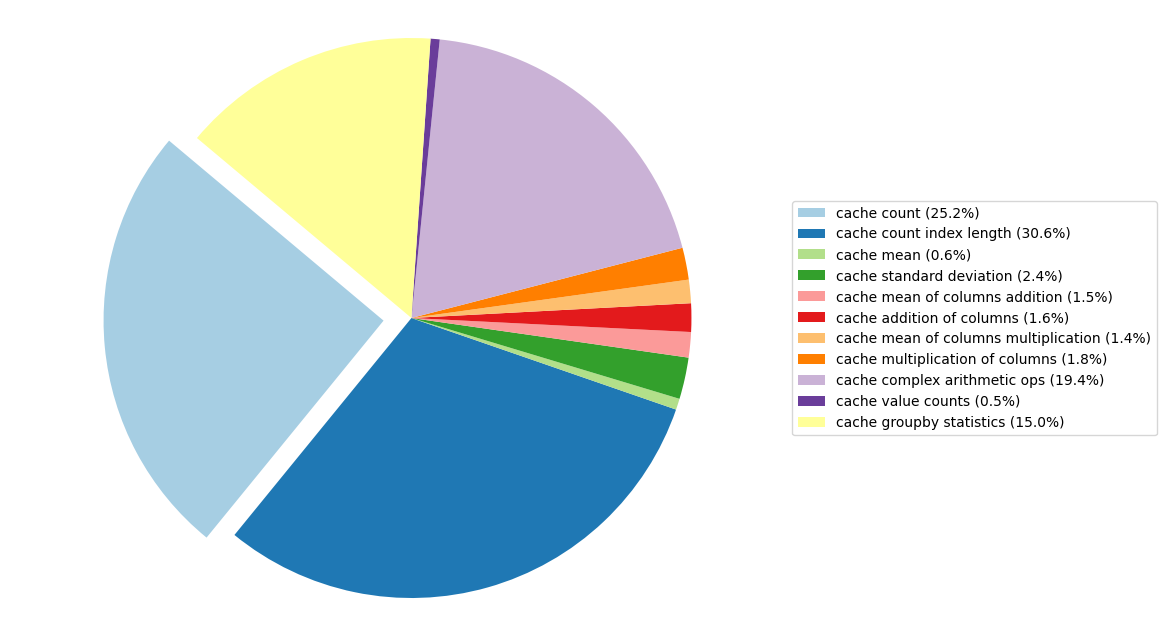

In [110]:
percentages = [f"{(d / sum(results_modin_cache2['duration']) * 100):.1f}%" for d in results_modin_cache2['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin_cache2['task'], percentages)]
colors = ['green' if task == 'read file' else color for task, color in zip(results_modin_cache2['task'], plt.cm.Paired.colors)]
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin_cache2['duration']))]
plt.figure(figsize=(10, 8))
plt.pie(results_modin_cache2['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)
plt.axis('equal')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Gráfico Pizza: Data de 3 meses

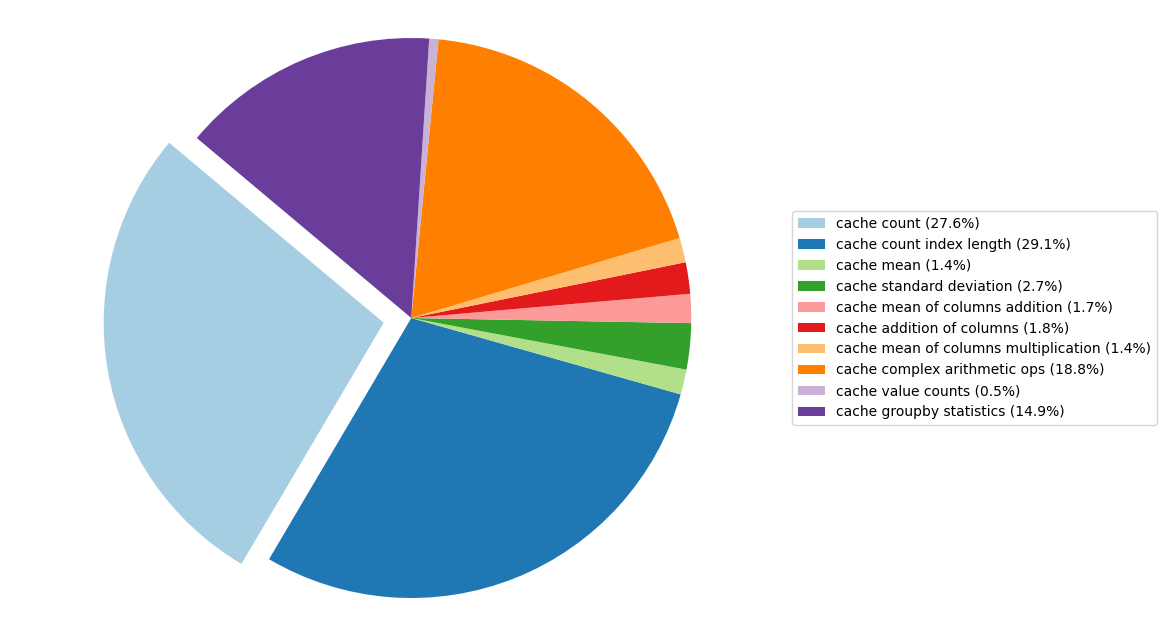

In [111]:
percentages = [f"{(d / sum(results_modin_cache3['duration']) * 100):.1f}%" for d in results_modin_cache3['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin_cache3['task'], percentages)]
colors = ['green' if task == 'read file' else color for task, color in zip(results_modin_cache3['task'], plt.cm.Paired.colors)]
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin_cache3['duration']))]
plt.figure(figsize=(10, 8))
plt.pie(results_modin_cache3['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)
plt.axis('equal')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Gráfico de linha: Data de 2 meses

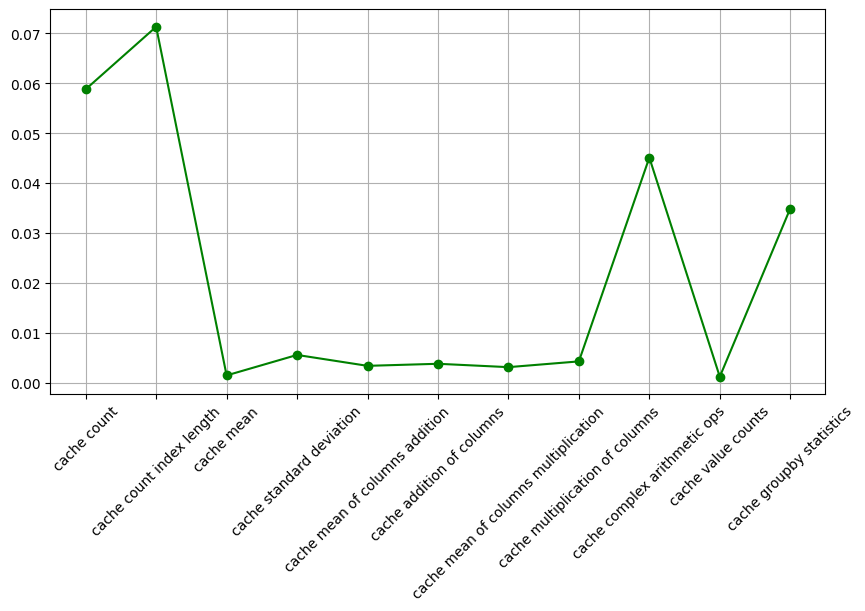

In [112]:
plt.figure(figsize=(10, 5))
plt.plot(results_modin_cache2['task'], results_modin_cache2['duration'], marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Gráfico de linha: Data de 3 meses

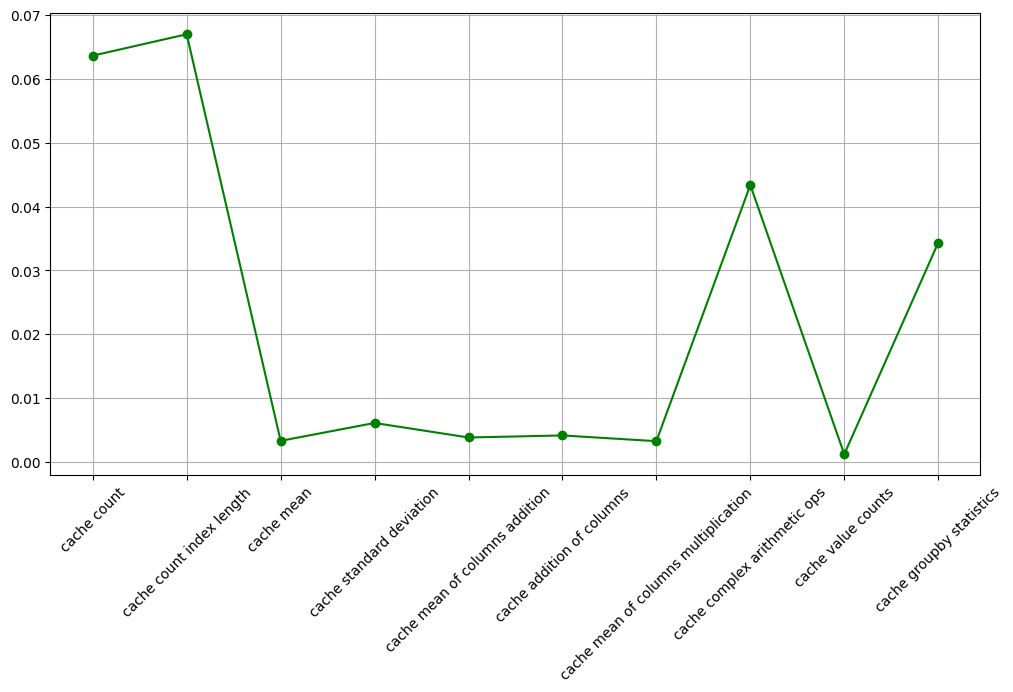

In [113]:
plt.figure(figsize=(12, 6))
plt.plot(results_modin_cache3['task'], results_modin_cache3['duration'], marker='o', linestyle='-', color='green')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()